# Finite Element and Neural Network Approach for Reliable Tunnel Support Pressure (σᵢ/sᵤ₀ₛ) Design

## Context
    Determining the required support pressure (σᵢ/sᵤ₀ₛ) to ensure tunnel stability is critical in geotechnical engineering. This study evaluates the minimum σi using Finite Element Limit Analysis (FELA) in Optum, validated across three tunnel geometries with varying cover-to-width ratios (D/B = 0.5, 1, 1.5) (as illustrated in the figure). The FELA results will train an Artificial Neural Network (ANN) to develop a predictive model for data-driven stability assessments, enabling rapid design optimizations for diverse tunnel configurations.

# Features

## Inputs / Features
    C/B: Cover depth to tunnel width ratio
    D/B: Tunnel depth to width ratio
    m: Shear strength increment rate with depth
    λ = su90/su0: Horizontal-to-vertical undrained shear strength ratio (s = undrained shear strength)
    µ = su45/su0: Inclined (45°)-to-vertical shear strength ratio
    γB/sᵤ₀ₛ	= Unit weight × width / shear strength ratio

## Output / Label
    σᵢ/sᵤ₀ₛ: Normalized tunnel support pressure

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm 

# dataset

In [3]:
df = pd.read_csv("data.csv")  # Replace with your file name


### dataset overview:

In [4]:
df.head()

,C/B,D/B,m,λ,μ,γB/su0s,σi/su0s
0,1,0.5,0.0,0.5,0.5,1,-0.327987
1,2,0.5,0.0,0.5,0.5,1,-0.098114
2,3,0.5,0.0,0.5,0.5,1,0.362250
3,4,0.5,0.0,0.5,0.5,1,0.960046
4,5,0.5,0.0,0.5,0.5,1,1.688114


### Adjusting font settings to match the formatting requirements of the actual dataset

In [5]:
subscript_u0s = '\u1D64\u2080\u209B'  # 'ᵤ₀ₛ'

# Rename column
df.rename(columns={'γB/su0s': f'γB/s{subscript_u0s}'}, inplace=True)

In [6]:
# Unicode subscript for i and u₀ₛ
subscript_i = '\u1D62'  # 'ᵢ'
subscript_u0s = '\u1D64\u2080\u209B'  # 'ᵤ₀ₛ'

# Rename column correctly
df.rename(columns={'σi/su0s': f'σ{subscript_i}/s{subscript_u0s}'}, inplace=True)

In [7]:
# new chnaged dataset
df.head()

,C/B,D/B,m,λ,μ,γB/sᵤ₀ₛ,σᵢ/sᵤ₀ₛ
0,1,0.5,0.0,0.5,0.5,1,-0.327987
1,2,0.5,0.0,0.5,0.5,1,-0.098114
2,3,0.5,0.0,0.5,0.5,1,0.362250
3,4,0.5,0.0,0.5,0.5,1,0.960046
4,5,0.5,0.0,0.5,0.5,1,1.688114


# Displaying summary information about the dataset

### Retrieving the minimum and maximum values of the feature

In [8]:
max_values = df.max()
min_values = df.min()

print("Maximum values in each column:")
print(max_values)

print("\nMinimum values in each column:")
print(min_values)

Maximum values in each column:
C/B         5.000000
D/B         1.500000
m           1.000000
λ           1.500000
μ           1.250000
γB/sᵤ₀ₛ     5.000000
σᵢ/sᵤ₀ₛ    27.338945
dtype: float64

Minimum values in each column:
C/B         1.000000
D/B         0.500000
m           0.000000
λ           0.500000
μ           0.500000
γB/sᵤ₀ₛ     1.000000
σᵢ/sᵤ₀ₛ   -20.382103
dtype: float64


# Performing Exploratory Data Analysis (EDA) to understand the data distribution and relationships

#### Overview of dataset structure and central tendencies

In [10]:
print("=== DataFrame Information ===")
df.info()
print("\n")

# Display summary statistics for numerical columns
print("=== Summary Statistics for Numerical Columns ===")
print(df.describe().transpose())

=== DataFrame Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   C/B      1170 non-null   int64  
 1   D/B      1170 non-null   float64
 2   m        1170 non-null   float64
 3   λ        1170 non-null   float64
 4   μ        1170 non-null   float64
 5   γB/sᵤ₀ₛ  1170 non-null   int64  
 6   σᵢ/sᵤ₀ₛ  1170 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 64.1 KB


=== Summary Statistics for Numerical Columns ===
          count      mean       std        min      25%       50%       75%  \
C/B      1170.0  3.000000  1.414818   1.000000  2.00000  3.000000  4.000000   
D/B      1170.0  1.000000  0.408423   0.500000  0.50000  1.000000  1.500000   
m        1170.0  0.346154  0.410832   0.000000  0.00000  0.000000  0.500000   
λ        1170.0  0.855769  0.341052   0.500000  0.50000  0.750000  1.000000   
μ        1170.0  0.855769

####  Identifying missing or null values in the dataset

In [12]:
# Check for missing values in the DataFrame
print("=== Missing Values in Each Column ===")
missing_values = df.isnull().sum()
print(missing_values)

# Display total missing values in the DataFrame
total_missing = missing_values.sum()
print(f"\nTotal Missing Values in the DataFrame: {total_missing}")

# no missing value at all

=== Missing Values in Each Column ===
C/B        0
D/B        0
m          0
λ          0
μ          0
γB/sᵤ₀ₛ    0
σᵢ/sᵤ₀ₛ    0
dtype: int64

Total Missing Values in the DataFrame: 0


### Visualizing inter-feature correlations

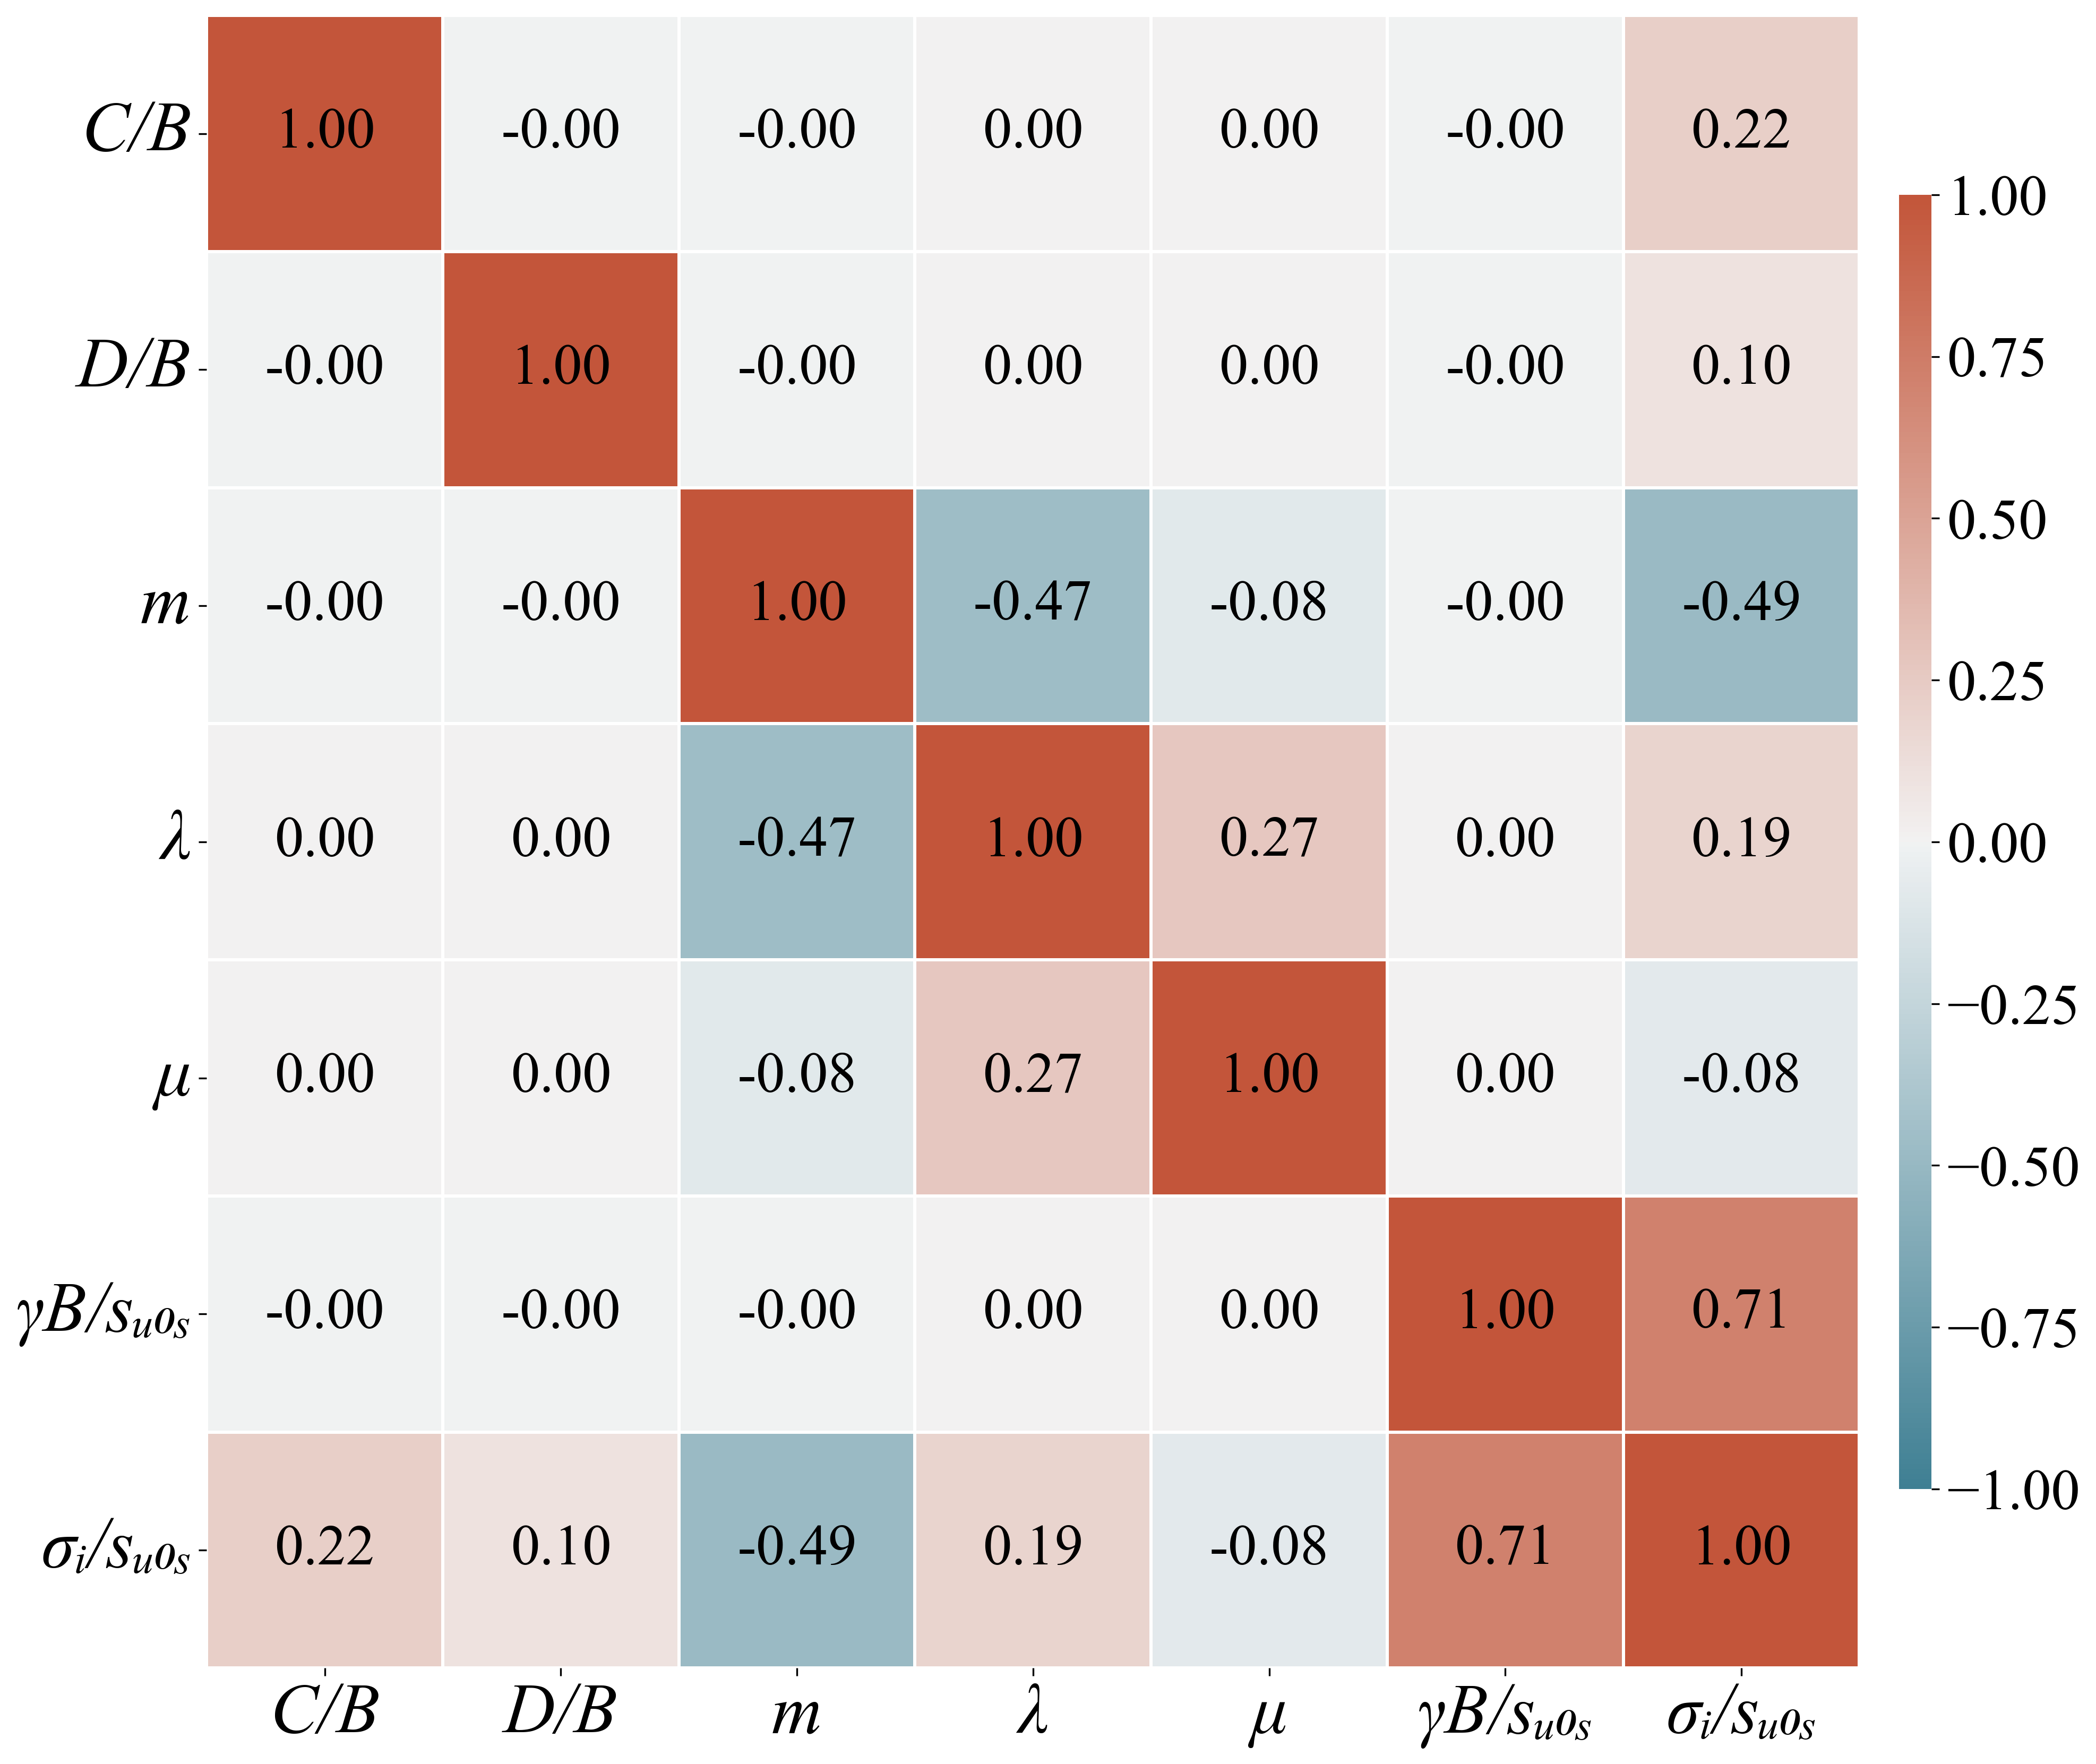

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute the correlation matrix
correlation_matrix = df.corr()

# Set Times New Roman as the default font globally
plt.rcParams["font.family"] = "Times New Roman"

# Create figure
fig, ax = plt.subplots(figsize=(14, 12), dpi=300)

# Create diverging color palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plot heatmap
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    linewidths=1,
    linecolor='white',
    square=True,
    cbar_kws={
        "shrink": 0.75,
        "aspect": 40,
        "pad": 0.02,
    },
    vmin=-1,
    vmax=1,
    center=0,
    annot_kws={
        "size": 26,
        "weight": "normal",
        "fontfamily": "Times New Roman",
        "color": "black"
    }
)

# Center X-axis labels
ax.set_xticks(np.arange(correlation_matrix.shape[1]) + 0.5)
ax.set_xticklabels(
    correlation_matrix.columns,
    rotation=0,
    ha='center',
    fontsize=32,
    weight='medium',
    style='italic'
)

# Format Y-axis labels
ax.set_yticklabels(
    correlation_matrix.index,
    rotation=0,
    fontsize=32,
    weight='medium',
    style='italic'
)

# Format colorbar
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(26)
colorbar.ax.tick_params(labelsize=26)

# Remove spines for a clean look
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# Tight layout and save
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


### Plotting probability density functions of fitted normal distributions

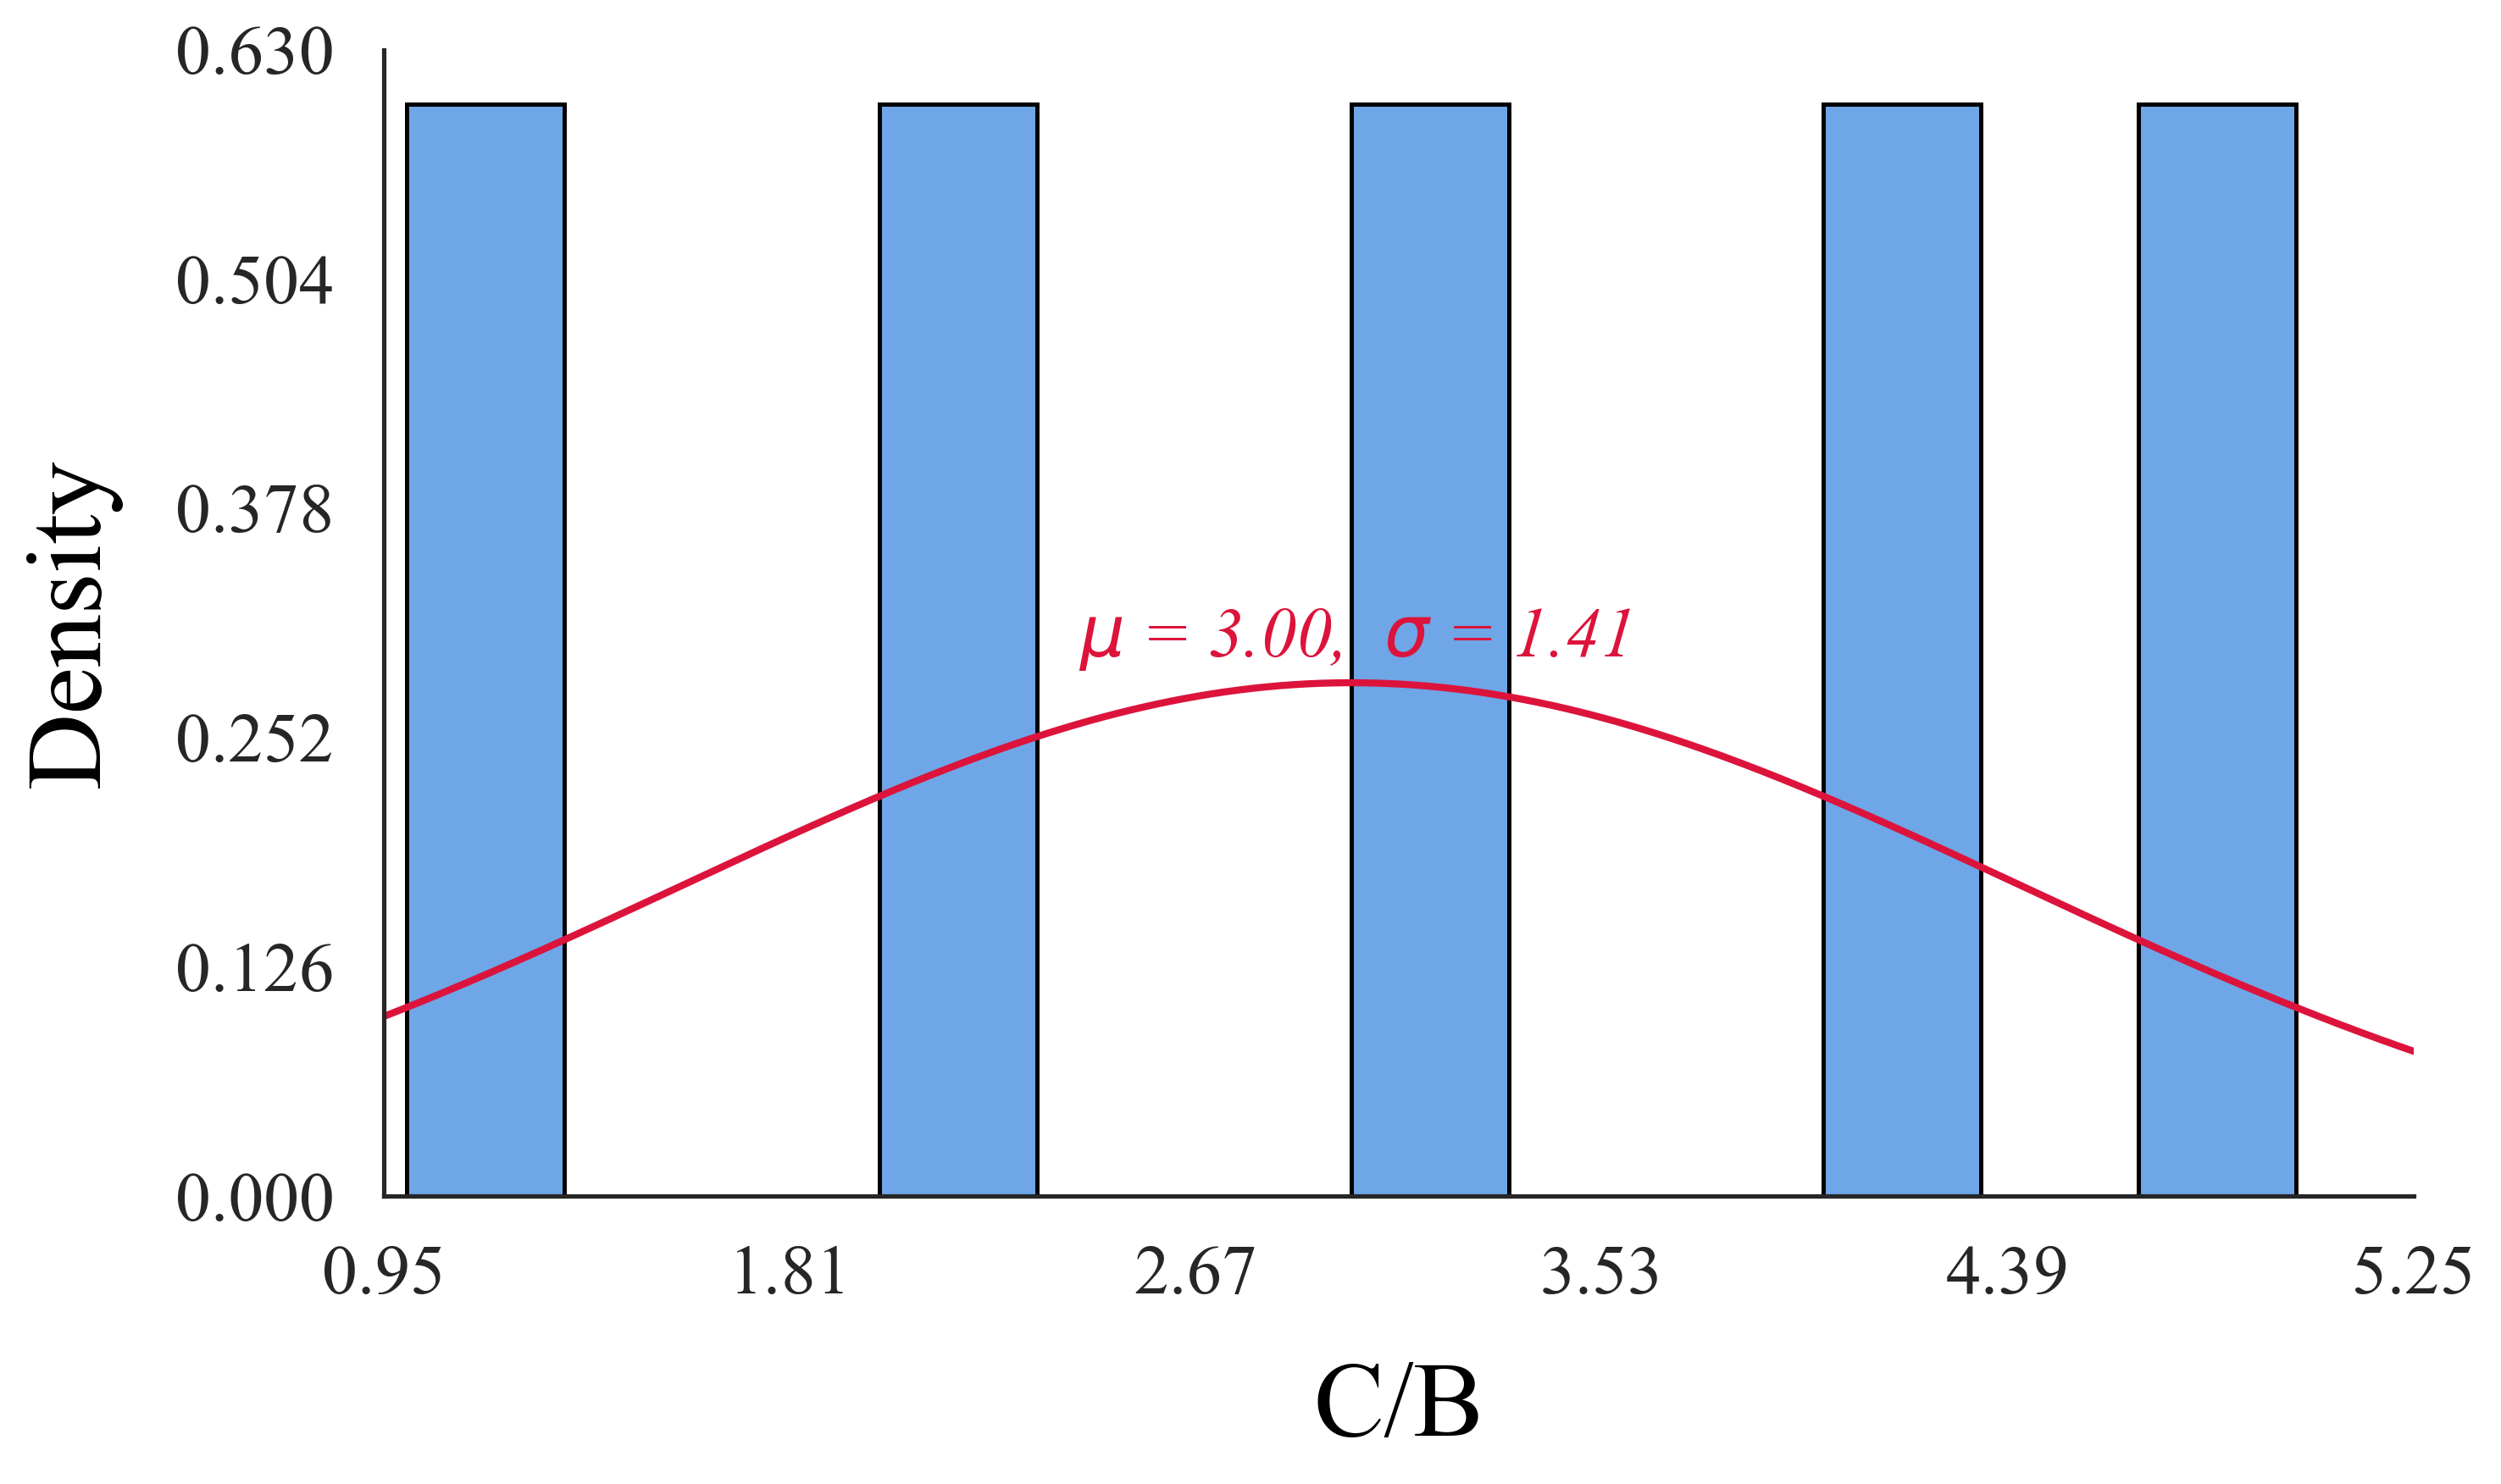

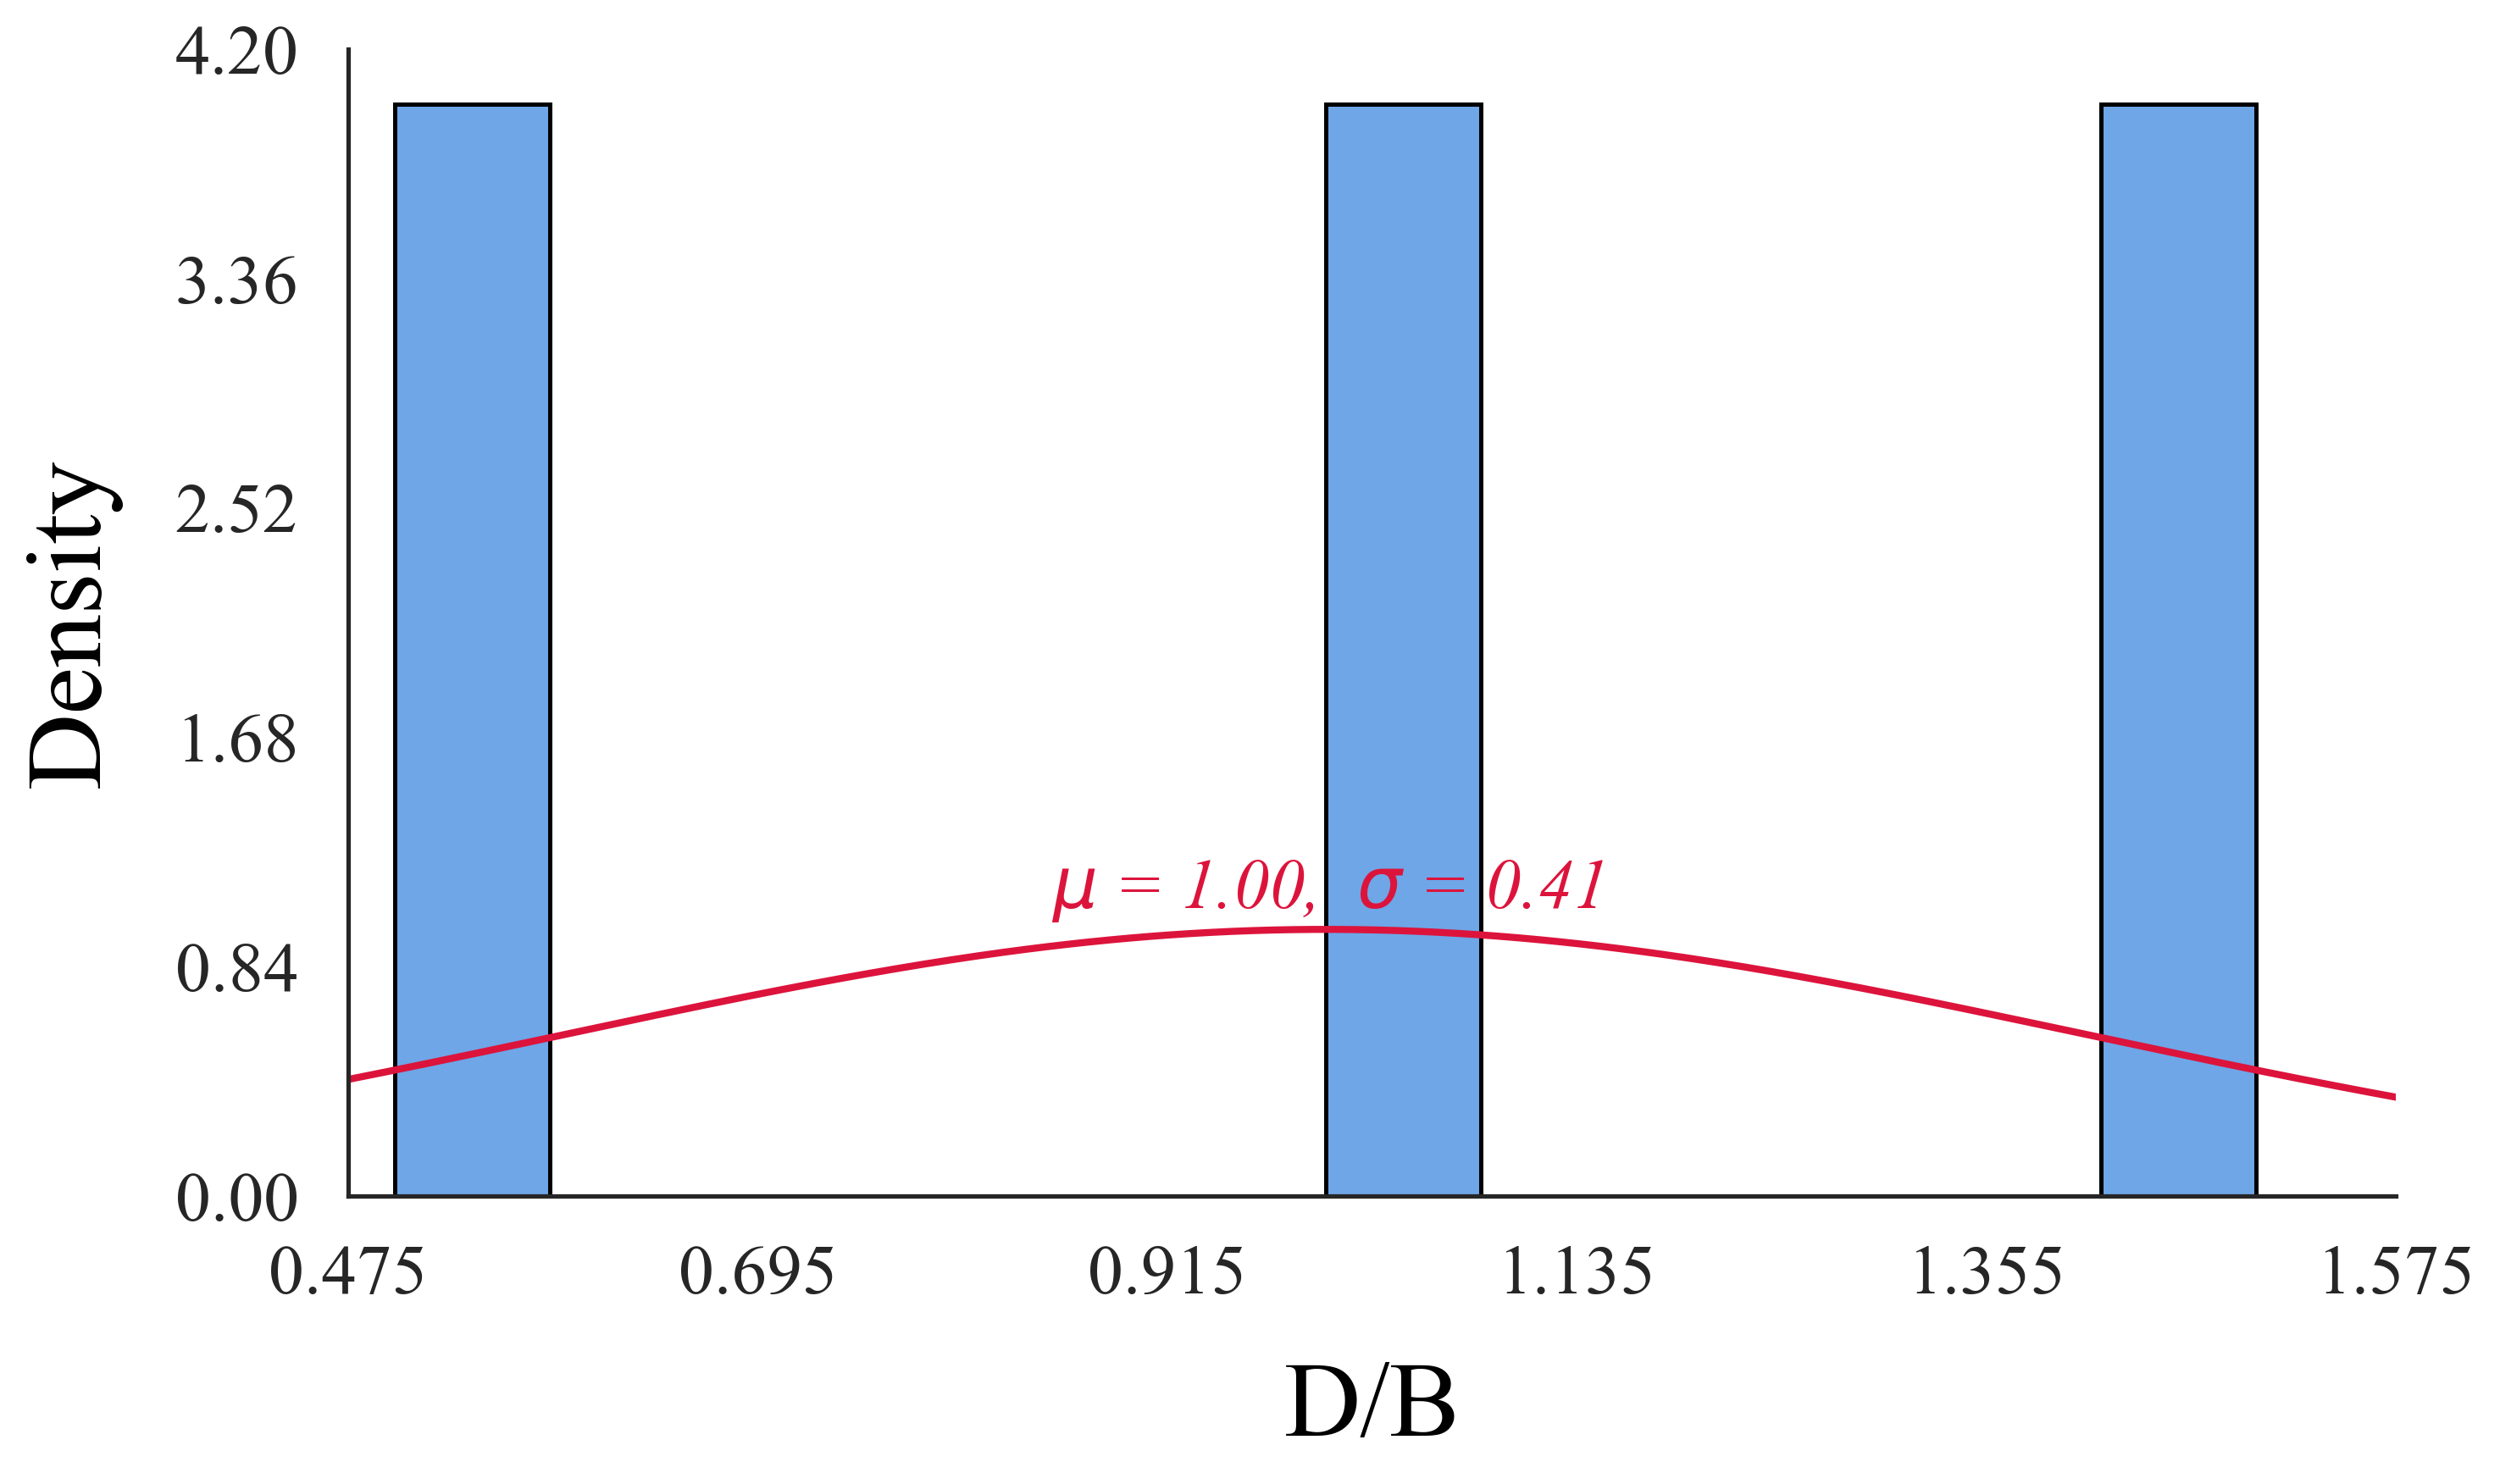

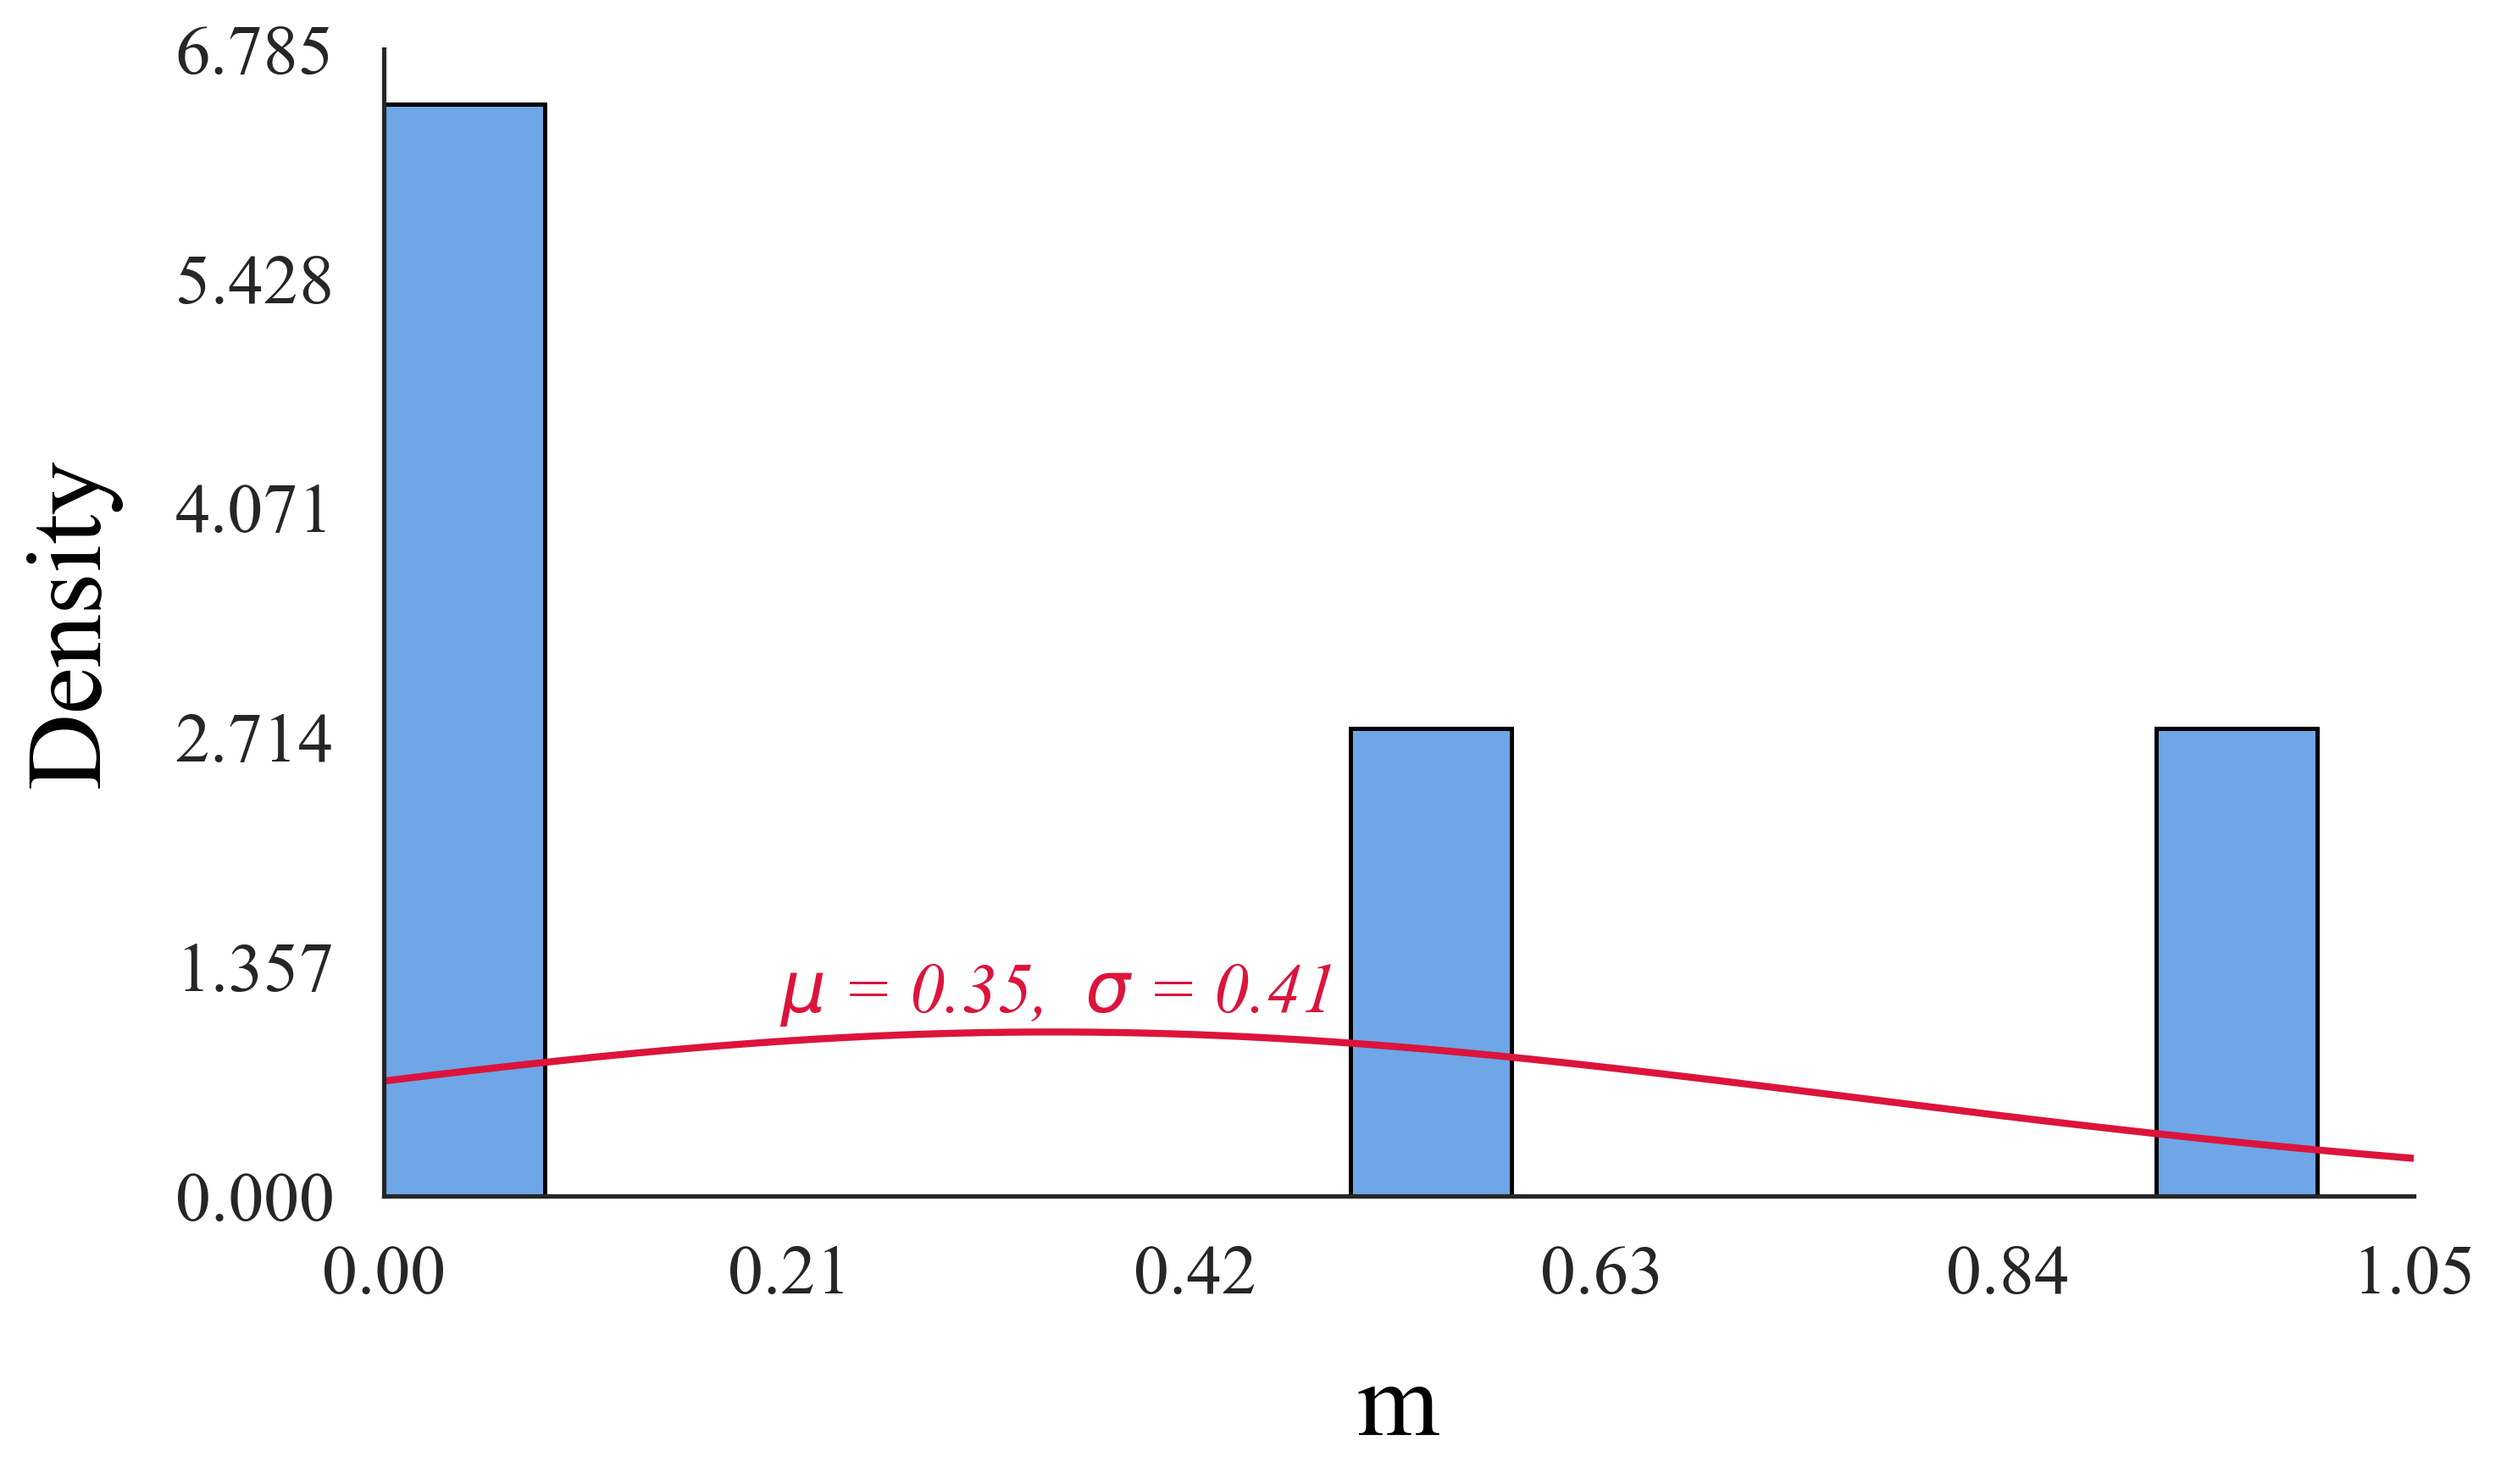

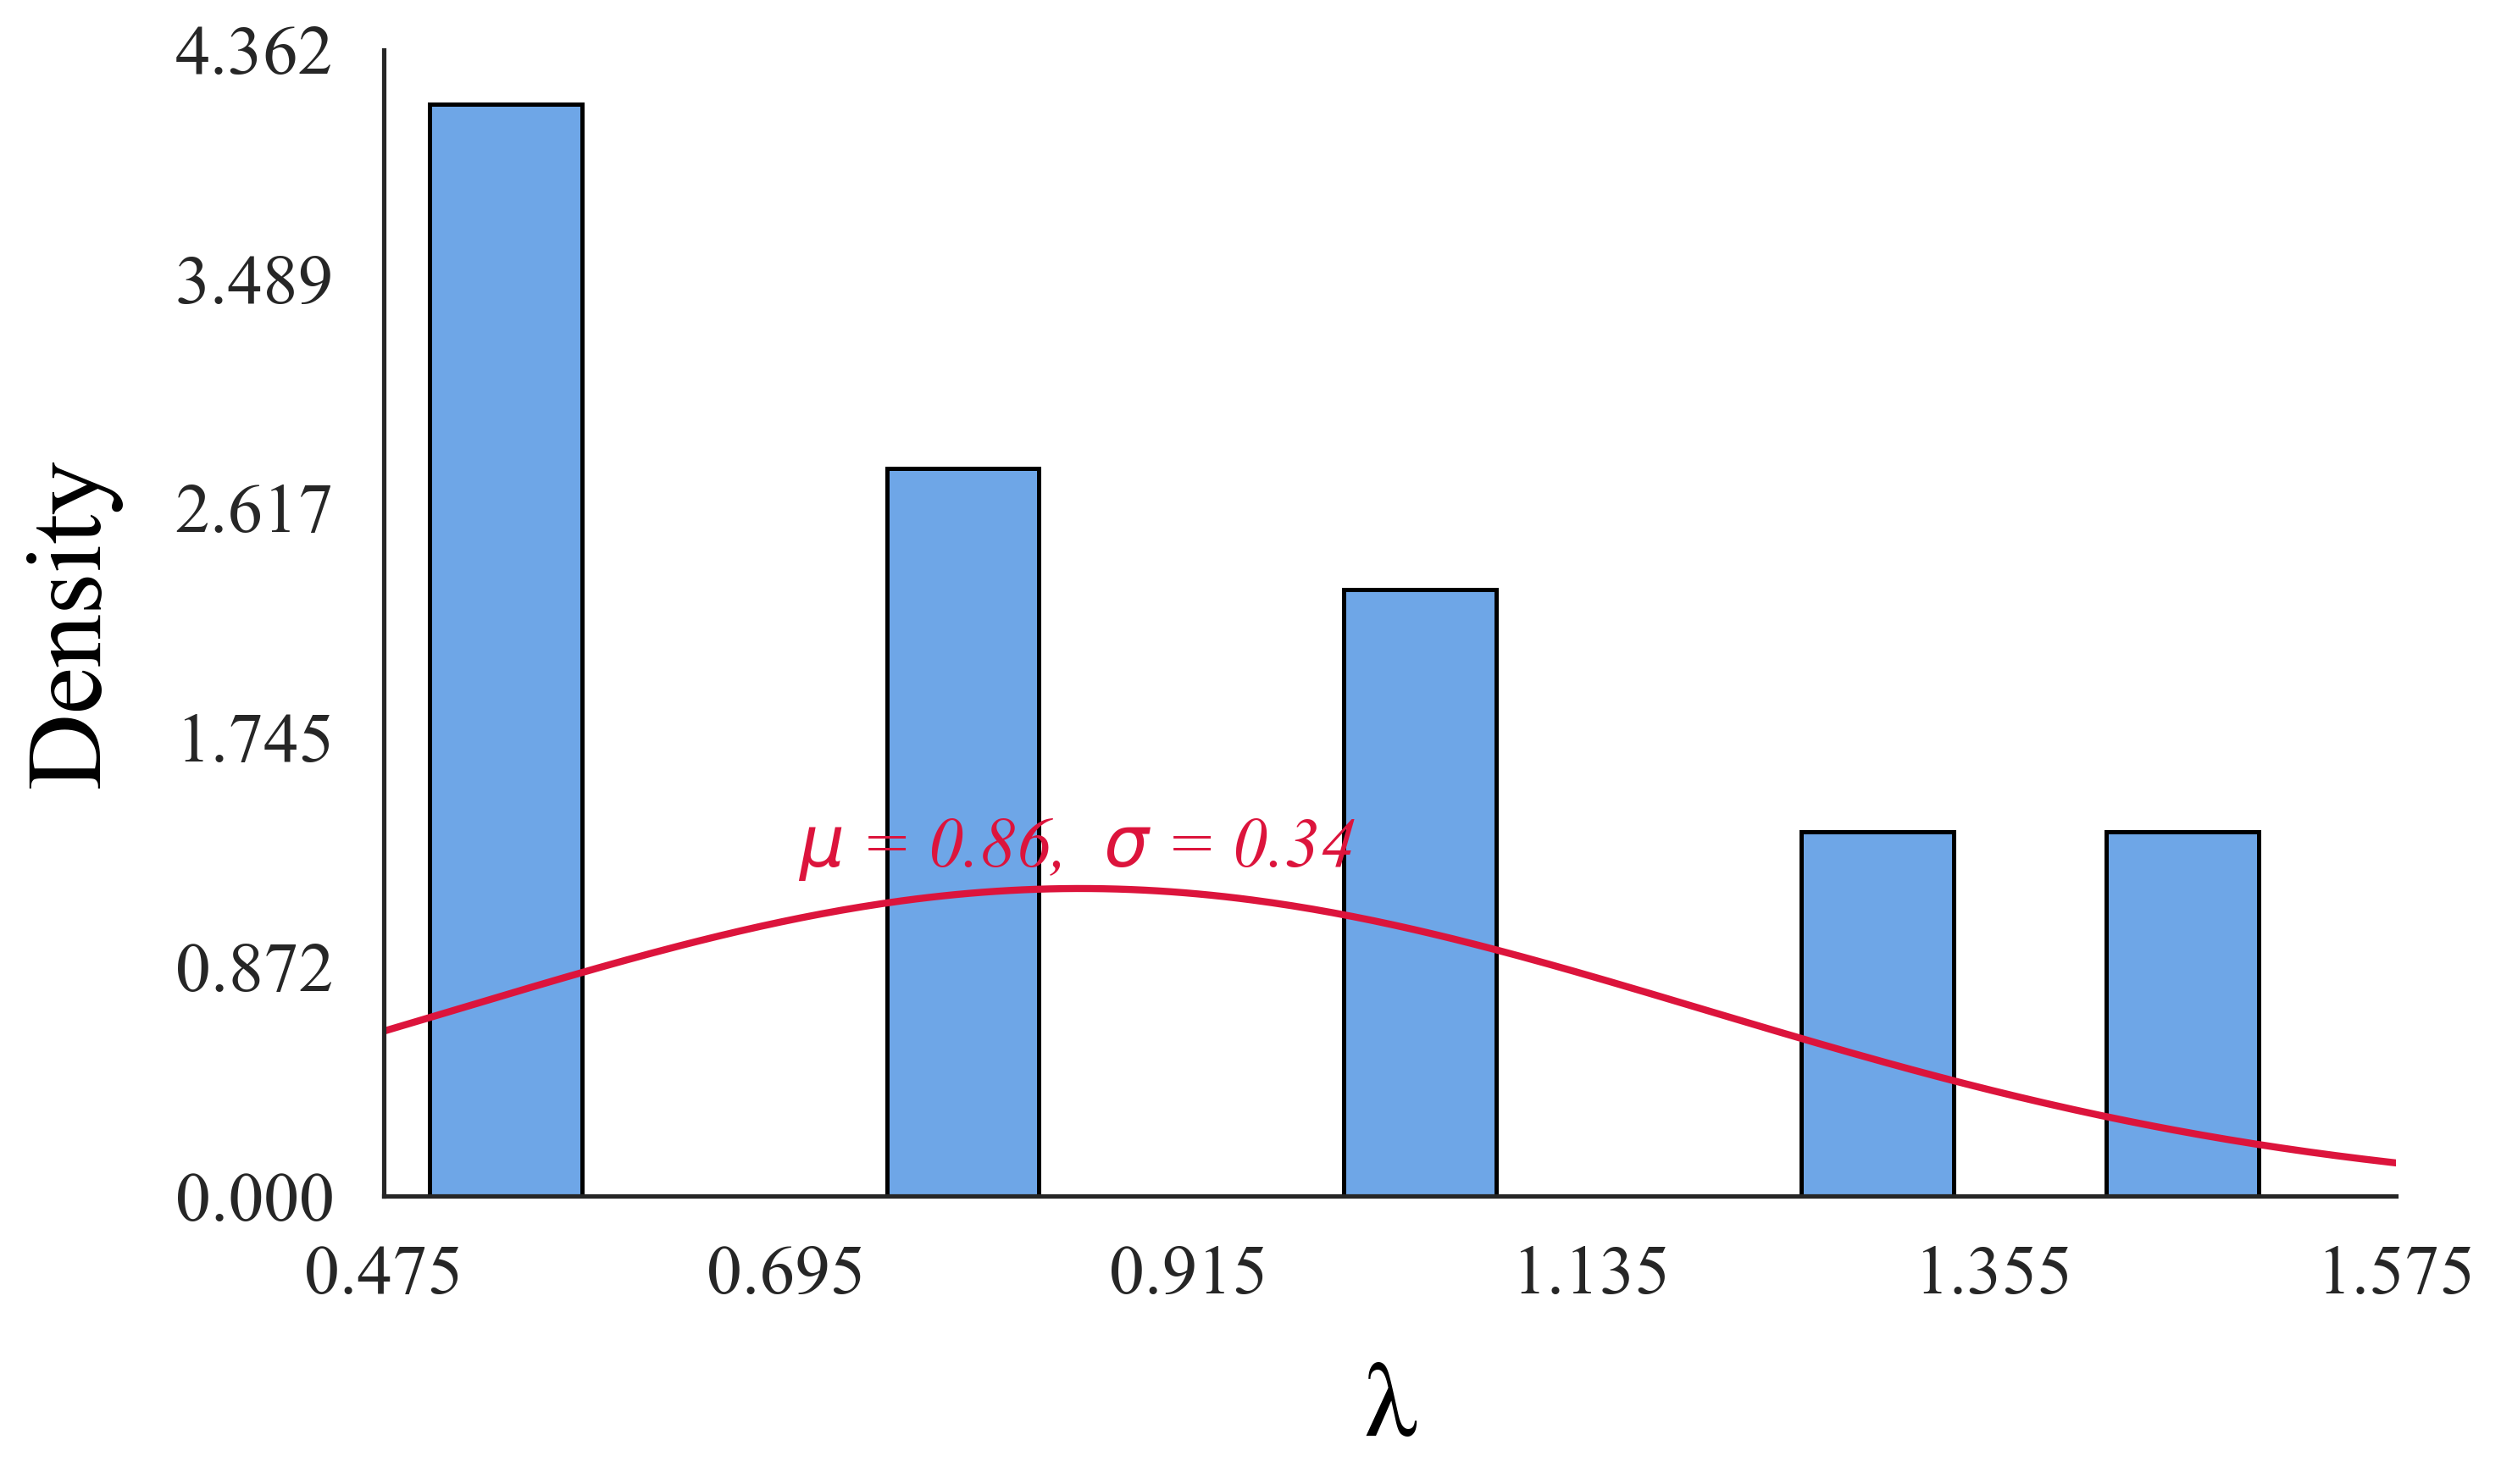

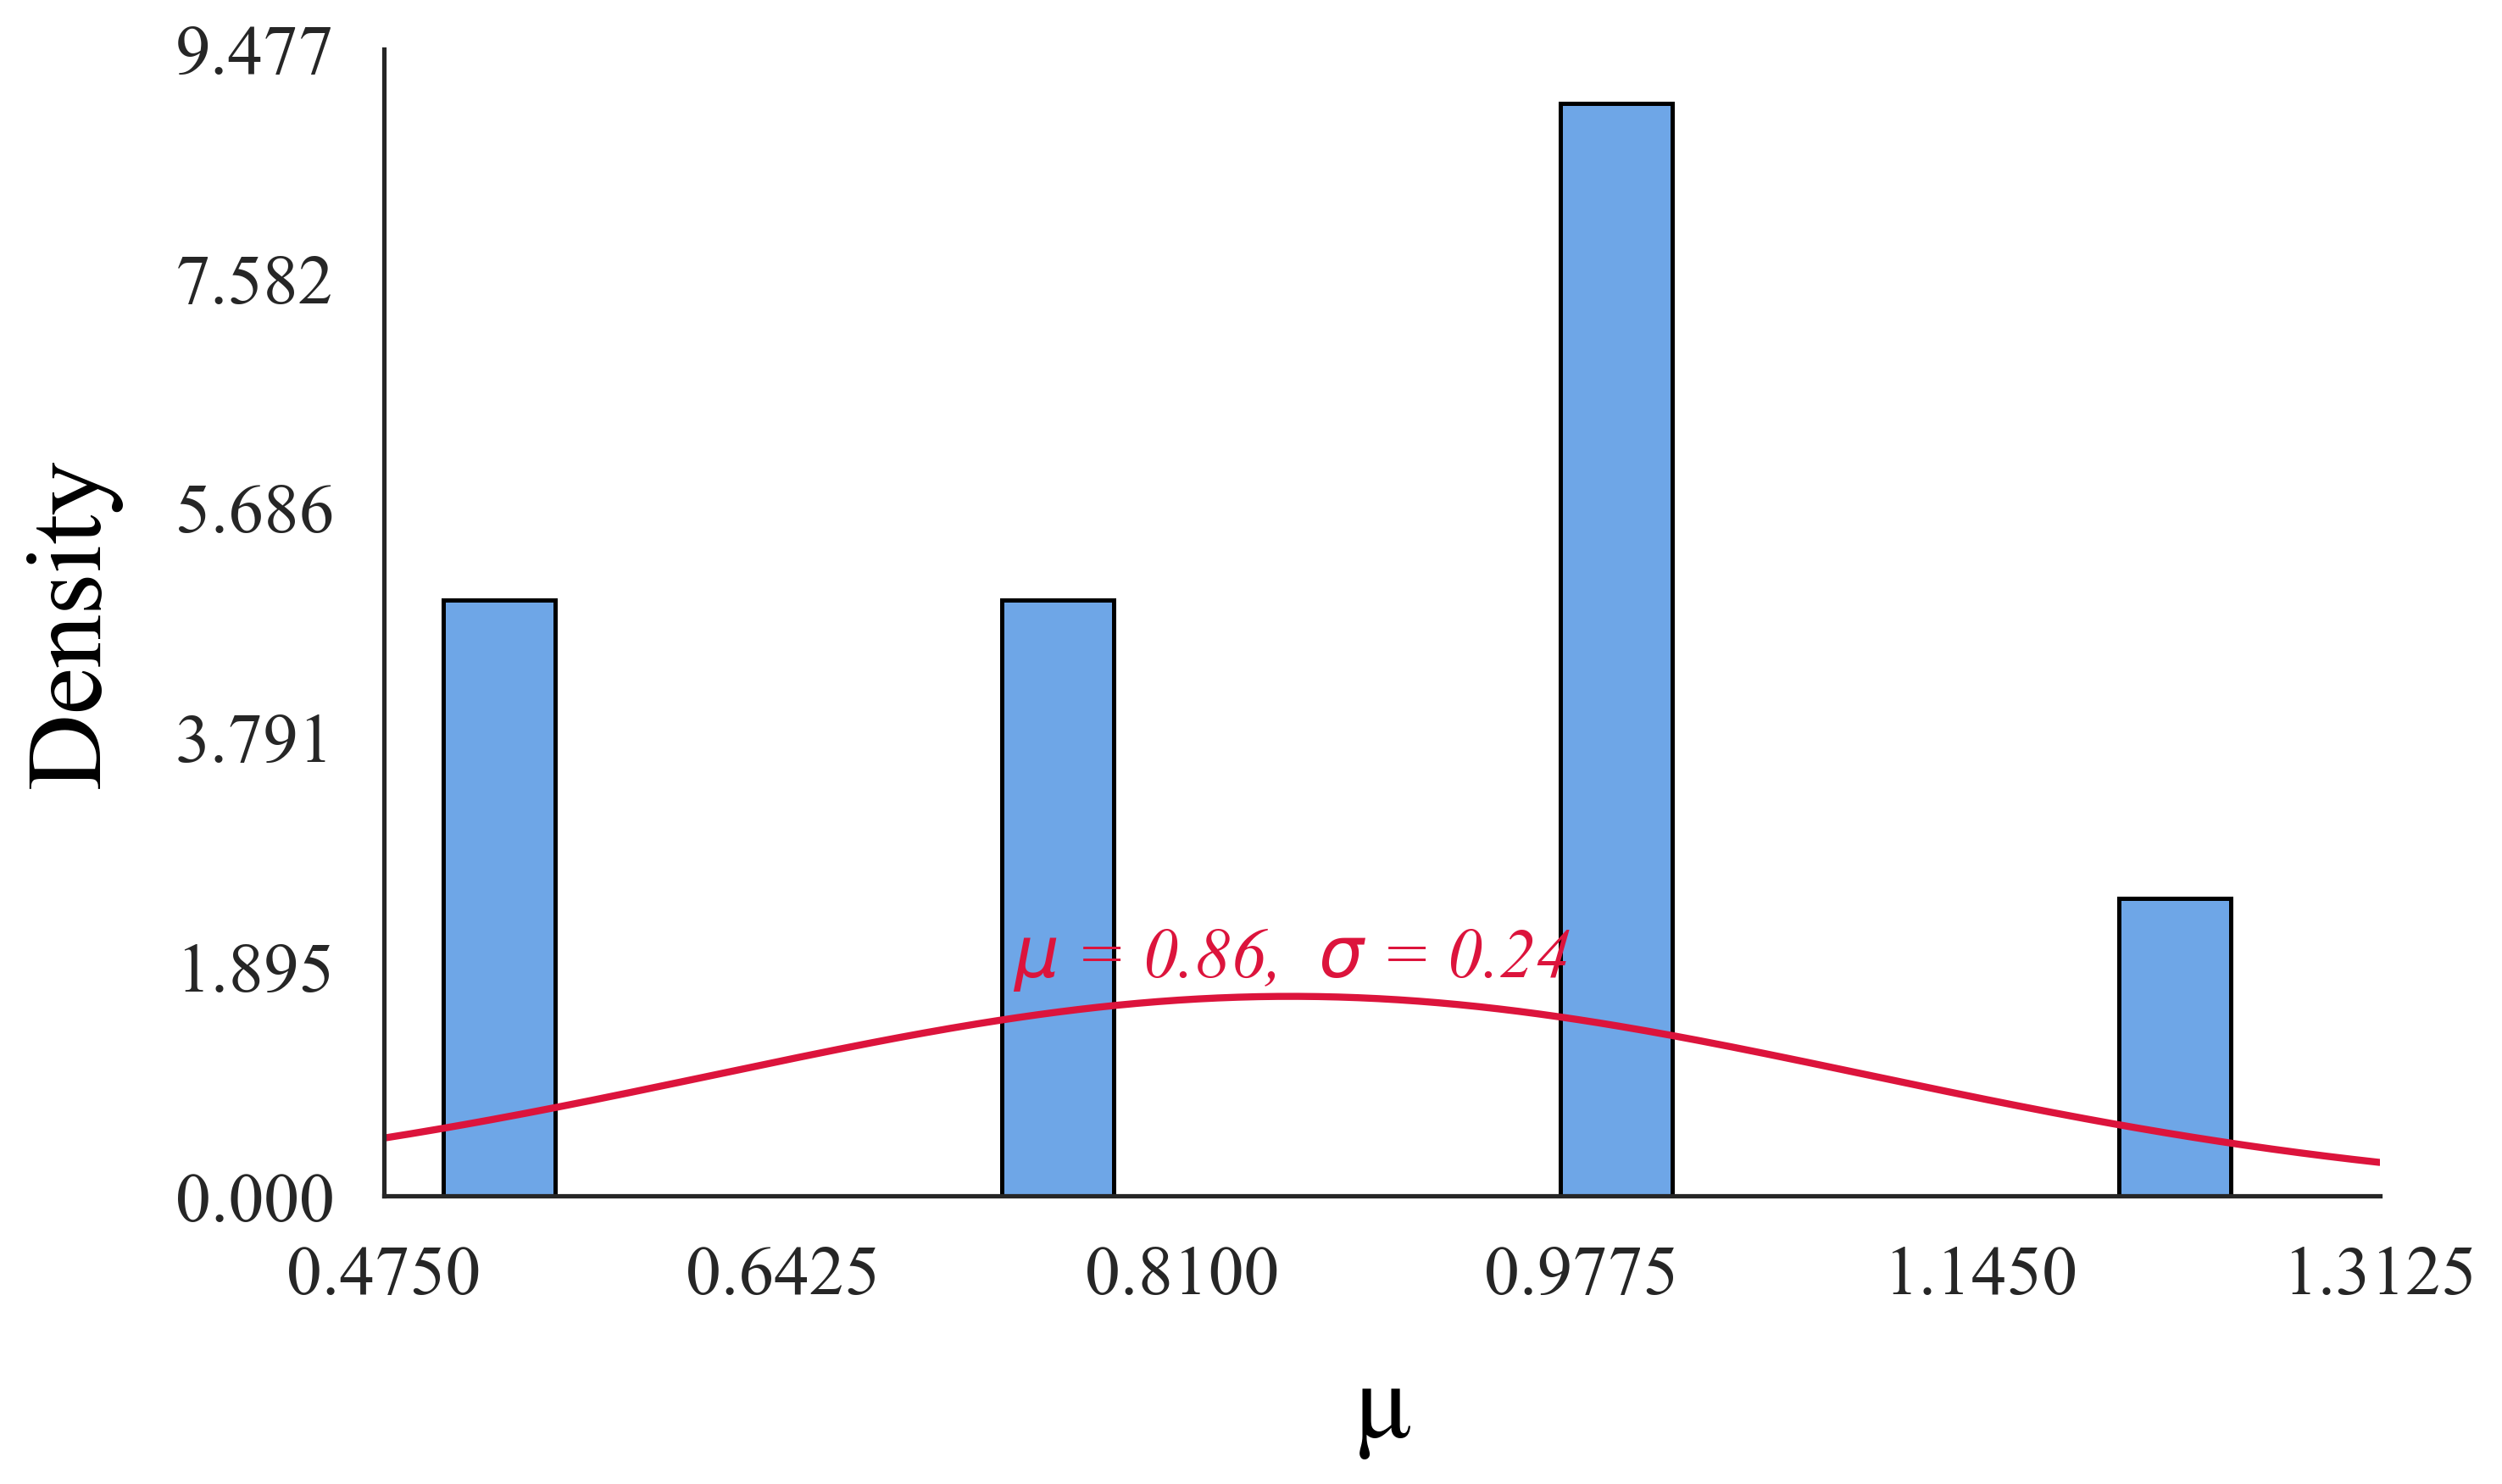

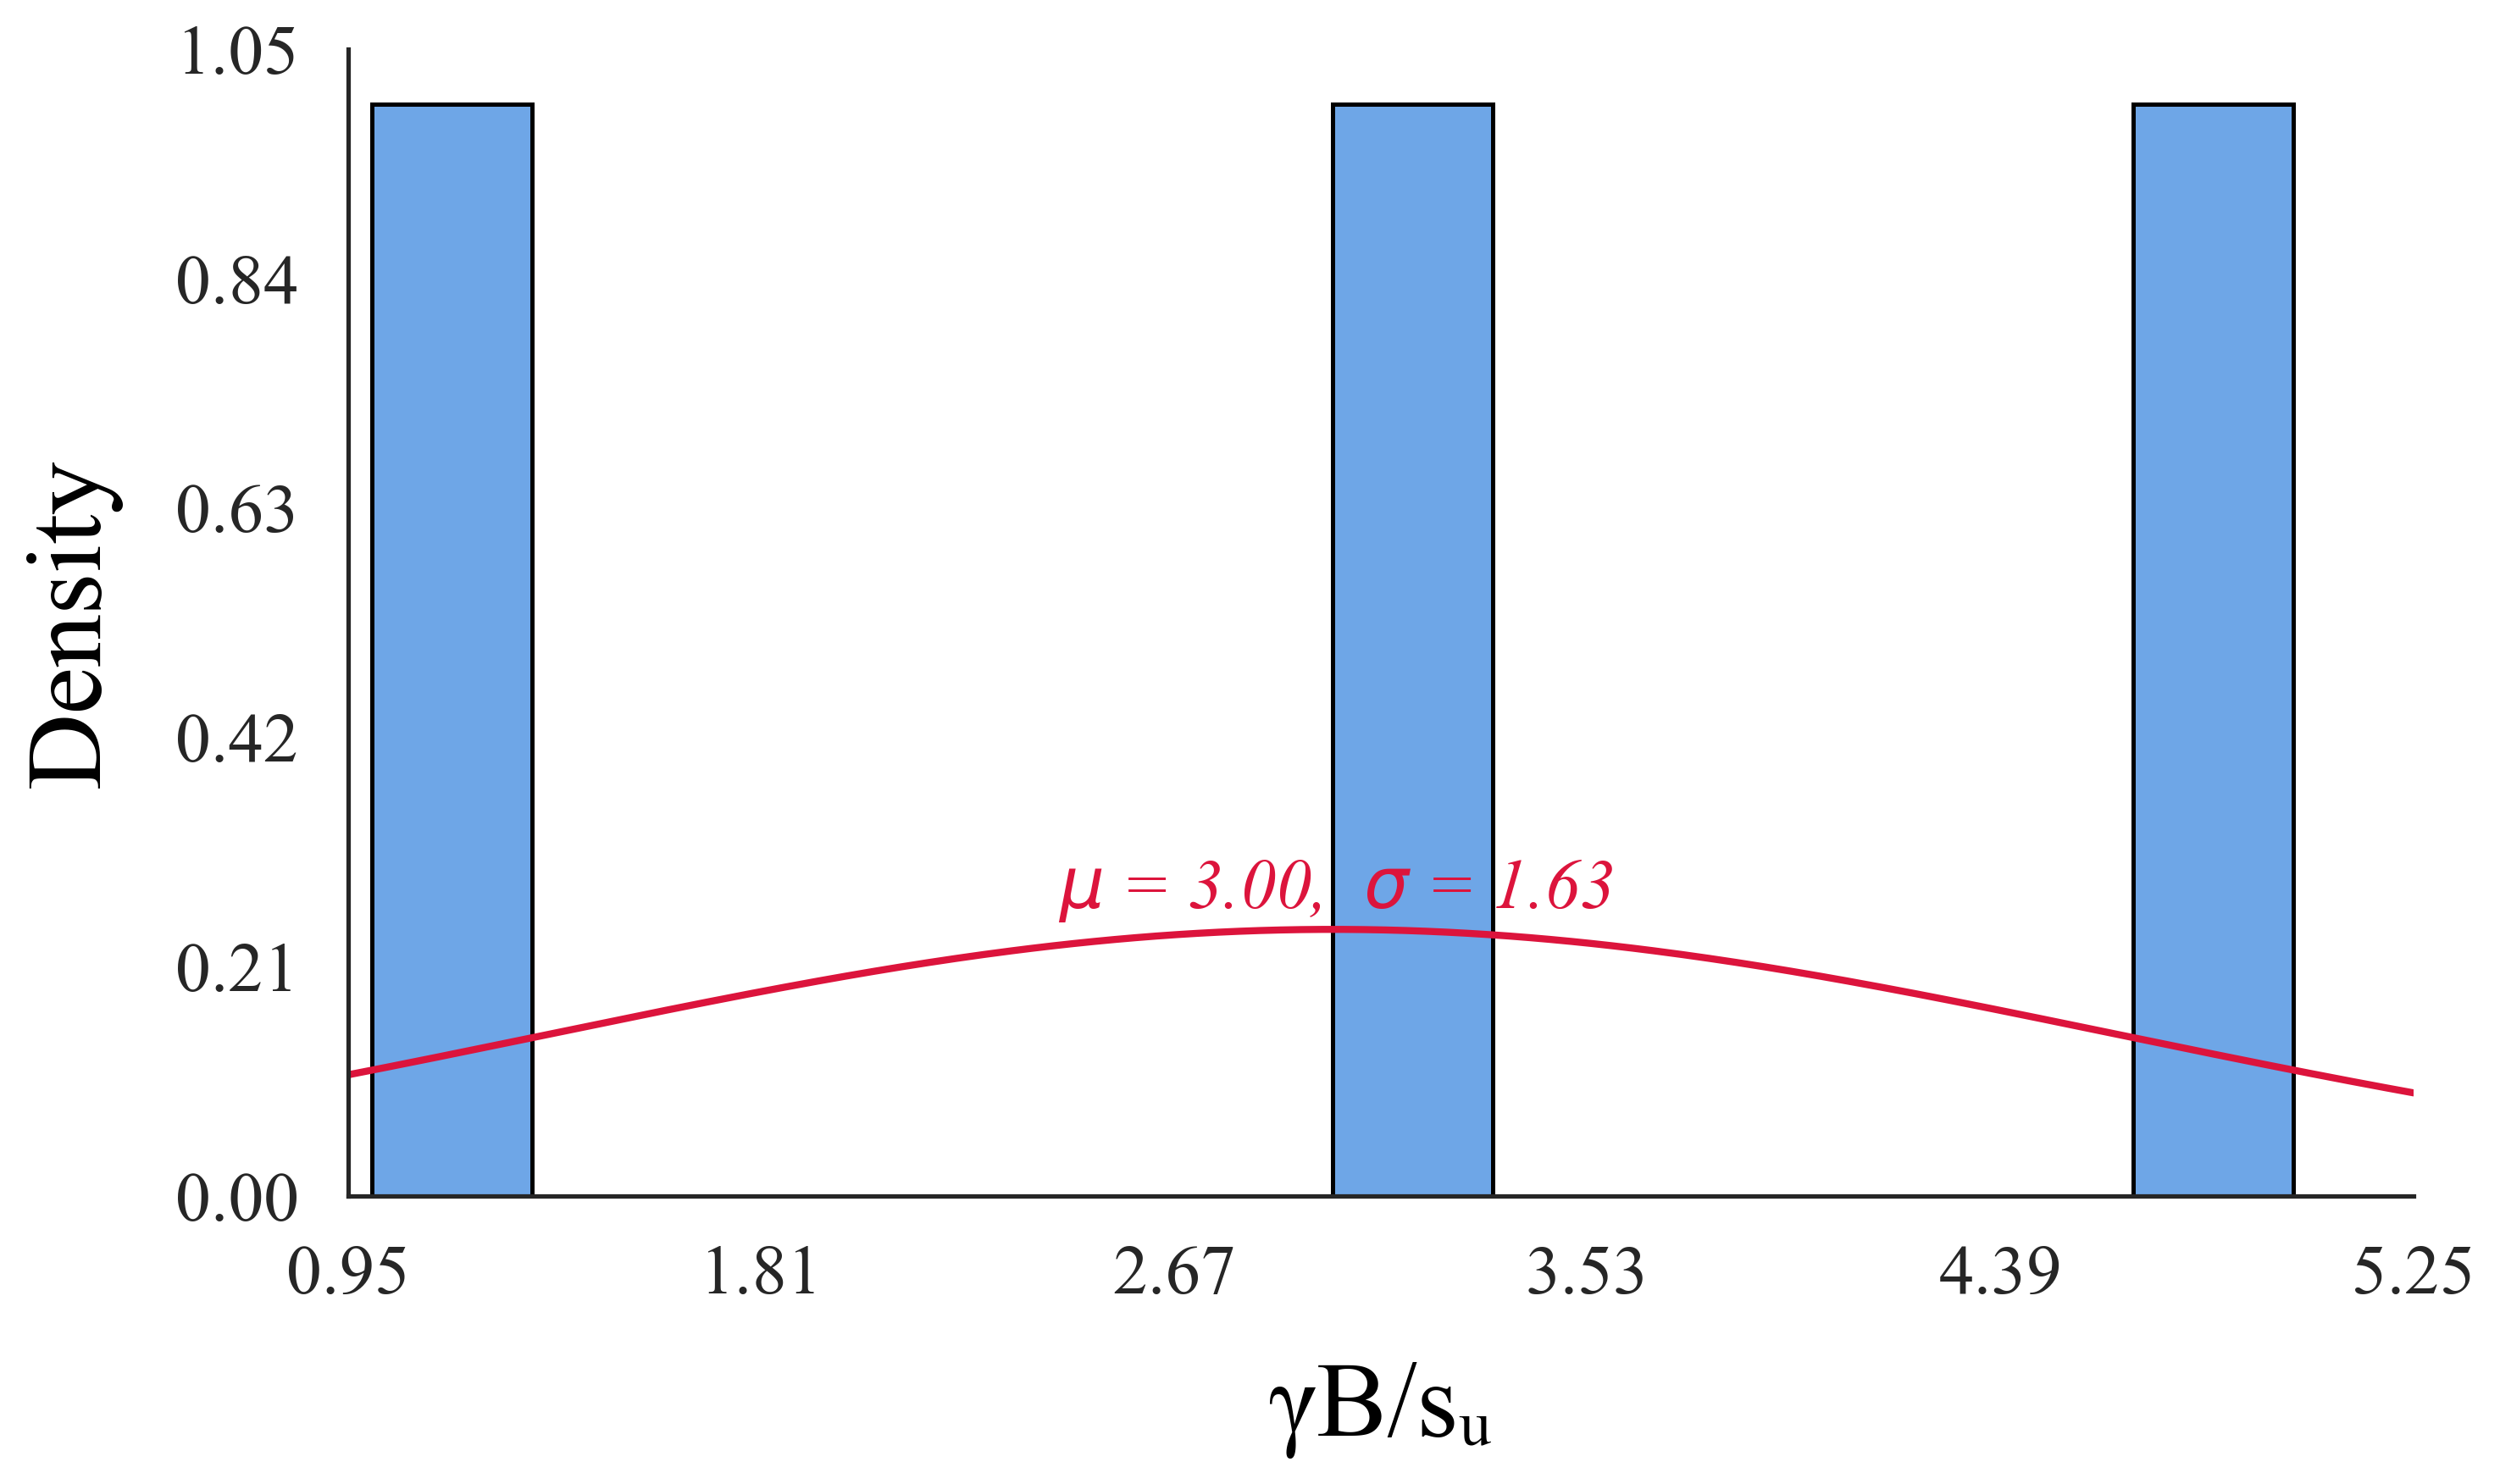

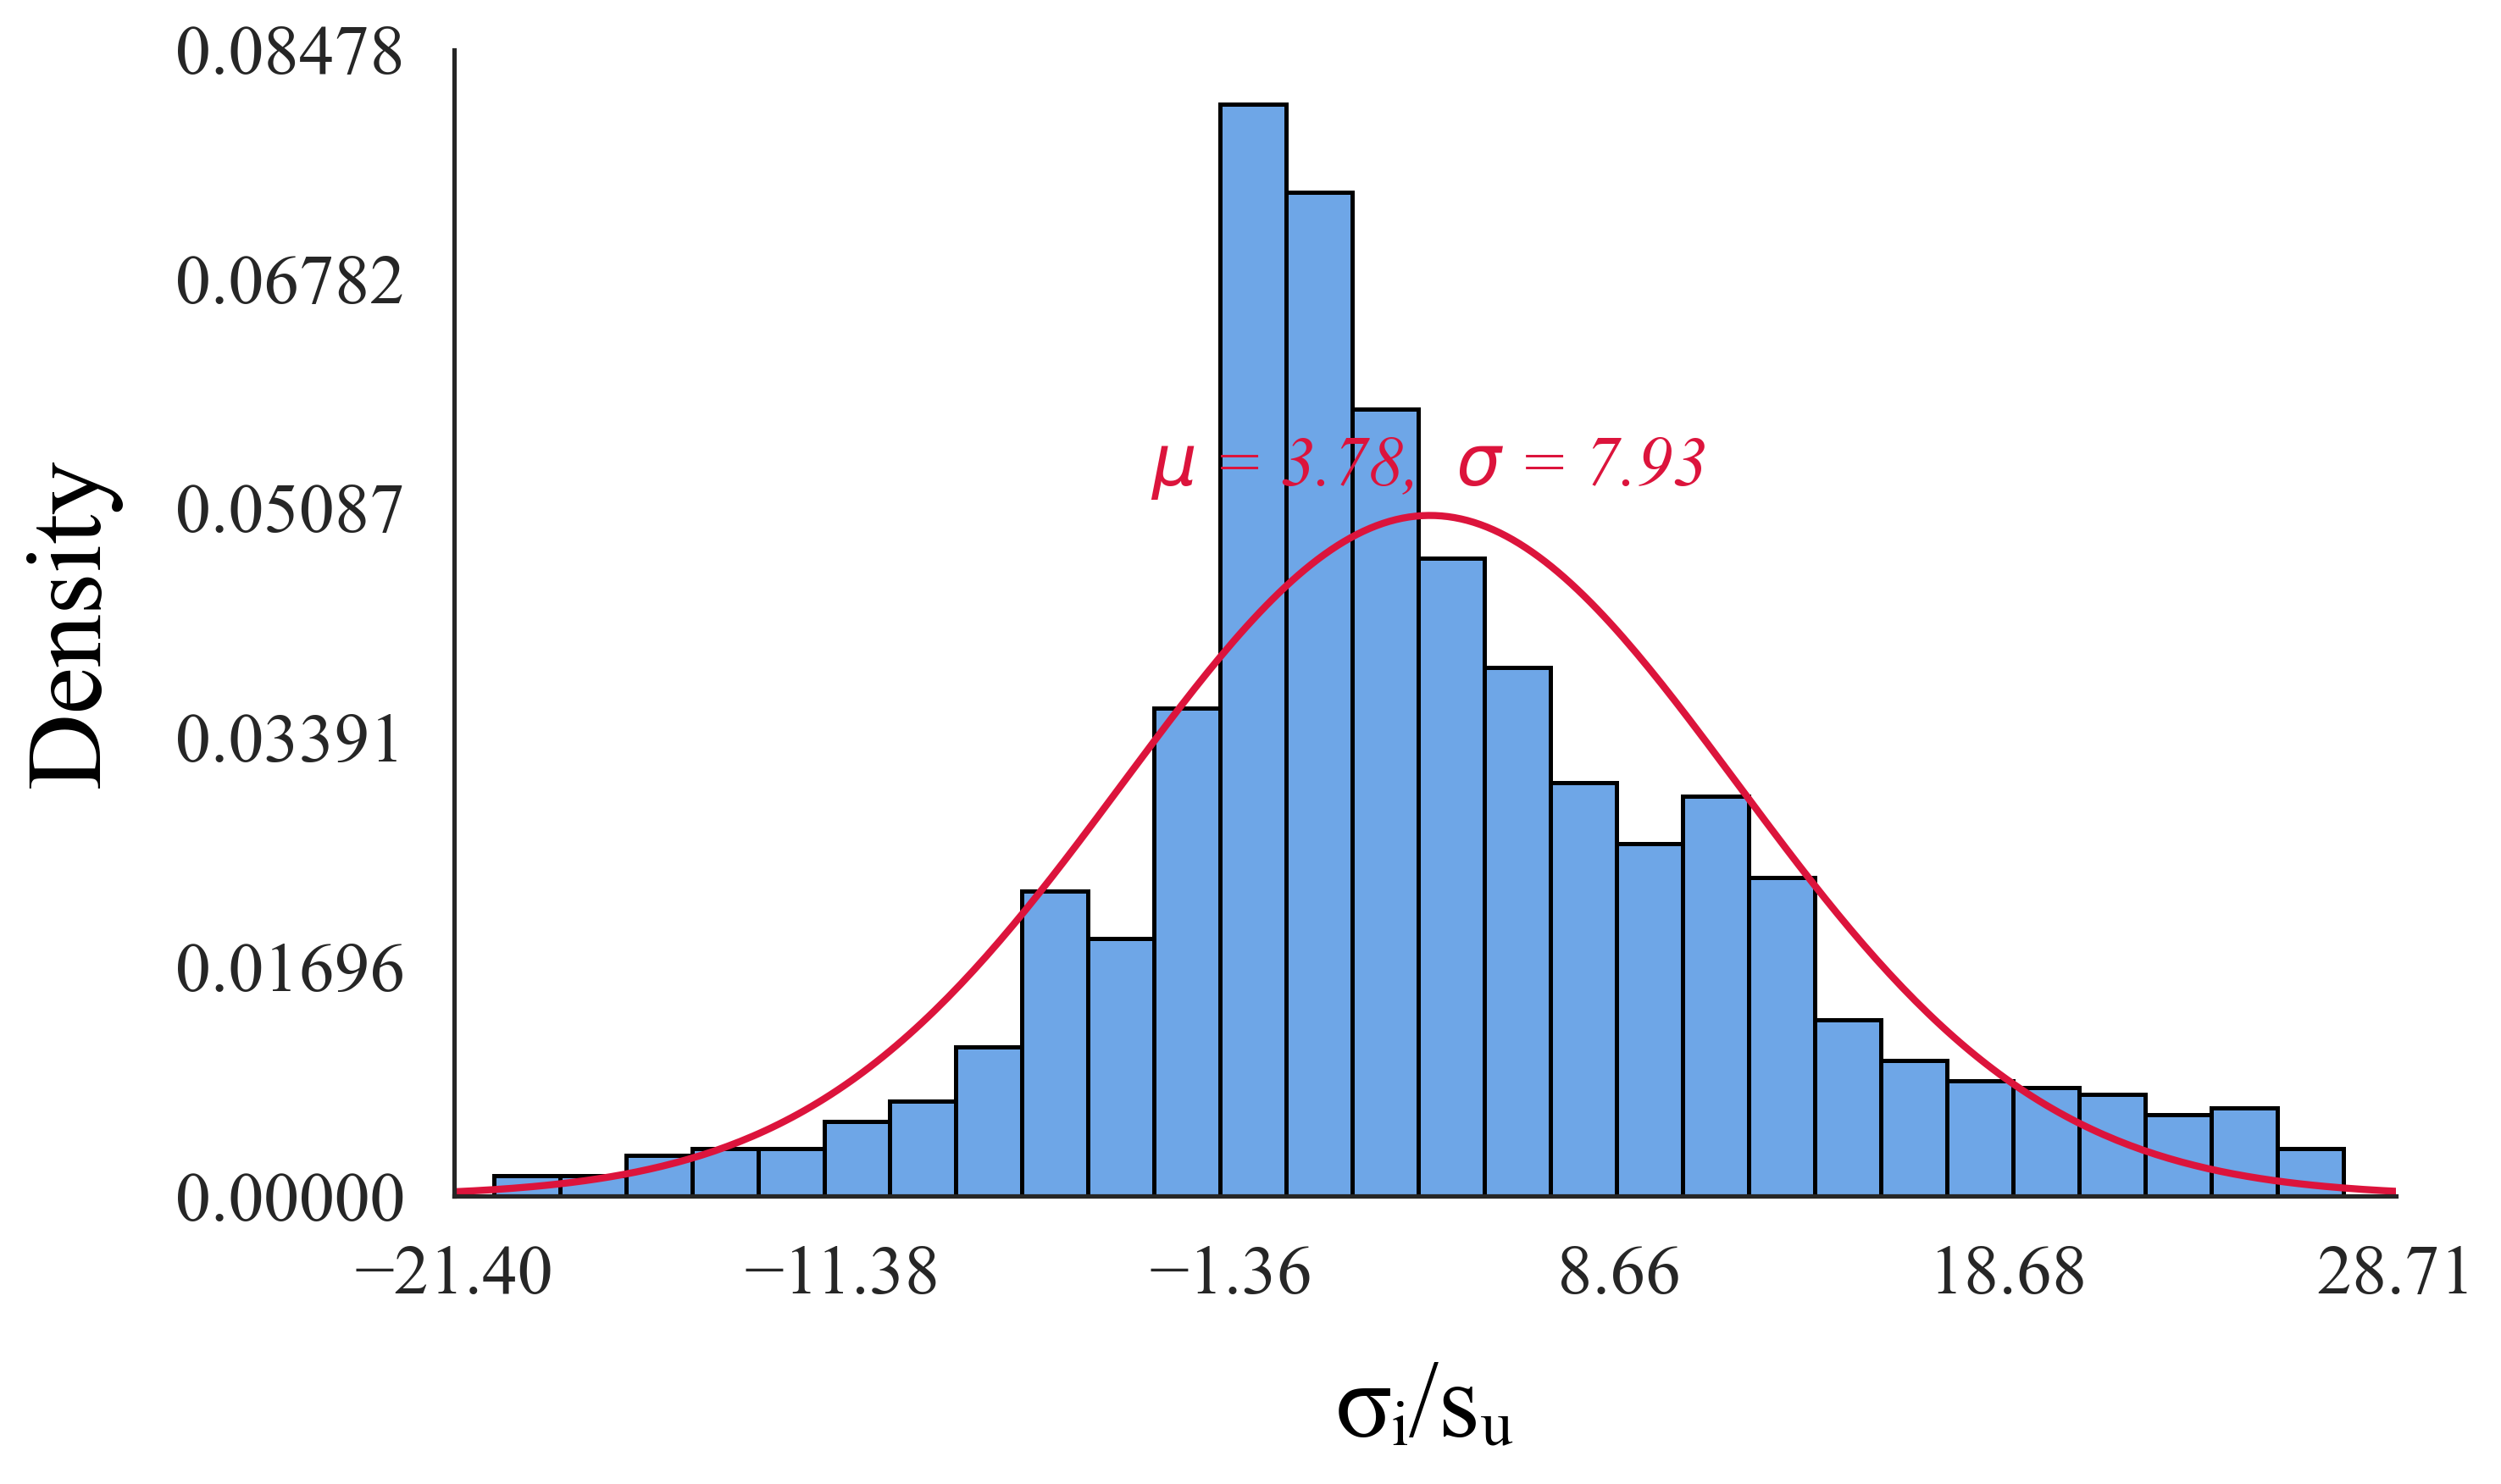

✅ All plots displayed with beautiful, correct LaTeX-style labels!


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Set style and font
sns.set_theme(style="white")
plt.rcParams["font.family"] = "Times New Roman"

# Manually map axis labels to LaTeX-formatted strings
latex_label_map = {
    'γB/sᵤ₀ₛ': r'$\gamma B / s_{u0s}$',
    'σ⁰': r'$\sigma^0$',
    'σ₀': r'$\sigma_0$',
    'τₛ': r'$\tau_s$',
    # Add more if needed
}

# Loop through columns
for column in df.columns:
    if column == 'output_column_name':
        continue

    data = df[column].dropna()

    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    # Histogram
    sns.histplot(
        data,
        color='#4A90E2',
        stat='density',
        bins='auto',
        edgecolor='black',
        linewidth=1.2,
        alpha=0.8,
        ax=ax
    )

    # Normal distribution fit
    mu, std = norm.fit(data)
    x = np.linspace(data.min() - 0.05 * abs(data.min()), data.max() + 0.05 * abs(data.max()), 300)
    p = norm.pdf(x, mu, std)
    ax.plot(
        x, p,
        color='crimson',
        linestyle='-',
        linewidth=2
    )

    # Annotate μ and σ
    ax.text(
        x[np.argmax(p)],
        max(p) + 0.02 * max(p),
        fr"$\mu$ = {mu:.2f},  $\sigma$ = {std:.2f}",
        fontsize=20,
        color='crimson',
        ha='center',
        va='bottom',
        fontstyle='italic'
    )

    # Axis labels
    xlabel = latex_label_map.get(column, column)
    ax.set_xlabel(xlabel, fontsize=30, fontweight='normal', color='black', labelpad=15)
    ax.set_ylabel("Density", fontsize=30, fontweight='normal', color='black', labelpad=15)

    # Clean style
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.tick_params(axis='both', which='major', labelsize=20, width=1.5, color='gray')
    ax.xaxis.set_tick_params(pad=8)
    ax.yaxis.set_tick_params(pad=8)

    # Ticks
    ax.set_xlim(x.min(), x.max())
    ax.set_xticks(np.linspace(x.min(), x.max(), 6))
    ax.set_ylim(bottom=0)
    ax.set_yticks(np.linspace(0, ax.get_ylim()[1], 6))

    plt.tight_layout()
    plt.show()

print("✅ All plots displayed with beautiful, correct LaTeX-style labels!")


### coordinates

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import os
import re

# 🎨 Set theme
sns.set_theme(style="white")

# 📢 Set font
plt.rcParams["font.family"] = "Times New Roman"

# 📁 Folders for plots and data
save_plot_folder = 'distribution_plots'
save_data_folder = 'distribution_data'
os.makedirs(save_plot_folder, exist_ok=True)
os.makedirs(save_data_folder, exist_ok=True)

# ✨ Sanitize filenames
def sanitize_filename(name):
    return re.sub(r'[\\/*?:"<>|]', "_", name)

# 🎯 Loop through each feature
for column in df.columns:
    if column == 'output_column_name':  # Skip output column if needed
        continue

    data = df[column].dropna()

    fig, ax = plt.subplots(figsize=(10, 6))

    # 🎨 Histogram
    counts, bins, _ = ax.hist(
        data,
        bins='auto',
        density=True,
        color='#4A90E2',
        edgecolor='black',
        linewidth=1.2,
        alpha=0.8
    )

    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # 📈 Normal distribution fit
    mu, std = norm.fit(data)
    x_fit = np.linspace(data.min() - 0.05 * abs(data.min()), data.max() + 0.05 * abs(data.max()), 300)
    y_fit = norm.pdf(x_fit, mu, std)

    ax.plot(x_fit, y_fit, color='crimson', linewidth=2.5, label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')

    # ✍️ Labels
    ax.set_xlabel(column, fontsize=30)
    ax.set_ylabel('Density', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 💾 Save figure
    safe_name = sanitize_filename(column)
    fig.savefig(os.path.join(save_plot_folder, f"{safe_name}.png"), dpi=600, bbox_inches='tight')
    plt.close(fig)

    # 💾 Save coordinates to CSV (pad shorter series with NaN)
    df_hist = pd.DataFrame({'Histogram_X': bin_centers, 'Histogram_Y': counts})
    df_fit = pd.DataFrame({'Normal_X': x_fit, 'Normal_Y': y_fit})
    df_coords = pd.concat([df_hist, df_fit], axis=1)

    df_coords.to_csv(os.path.join(save_data_folder, f"{safe_name}_coords.csv"), index=False)

print("✅ All distribution plots and coordinate CSVs saved!")


✅ All distribution plots and coordinate CSVs saved!


# Initiating Deep Learning: Model Architecture with ReLU Activation

###  Splitting the dataset into training (80%) and testing (20%) sets, followed by standardization of features


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Split dataset
X = df.drop(columns=['σᵢ/sᵤ₀ₛ'])  # Input features
y = df['σᵢ/sᵤ₀ₛ']  # Output column

# Train-test split (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize StandardScaler for input (X)
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Convert X back to DataFrame (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Initialize StandardScaler for output (y)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Convert y back to DataFrame (optional)
y_train_scaled = pd.DataFrame(y_train_scaled, columns=['σᵢ/sᵤ₀ₛ'])
y_test_scaled = pd.DataFrame(y_test_scaled, columns=['σᵢ/sᵤ₀ₛ'])

# Display first few rows of normalized X and y
print("X_train_scaled:")
print(X_train_scaled.head())

print("\ny_train_scaled:")
print(y_train_scaled.head())

X_train_scaled:
        C/B       D/B         m         λ         μ   γB/sᵤ₀ₛ
0  1.419920  1.211448  1.590497  0.422507  0.577684  0.014453
1  1.419920  1.211448 -0.840042  0.422507 -1.497986 -1.215357
2  0.008295  1.211448  1.590497 -1.036778 -0.460151 -1.215357
3  1.419920 -1.240261 -0.840042  1.152149 -1.497986  1.244263
4 -1.403331  1.211448  1.590497 -1.036778 -0.460151  0.014453

y_train_scaled:
    σᵢ/sᵤ₀ₛ
0 -1.214792
1 -0.111761
2 -1.500683
3  2.448611
4 -0.496677


###  Defining a neural network layer with 18 neurons using ReLU and tanh activation functions

In [25]:
# A single hidden layer neural network was implemented with 18 neurons using the ReLU activation function.
# The tanh activation function was also employed in the network.
# Early stopping was applied to mitigate overfitting.
# Model performance metrics:
# - R² Score: 0.9990
# - Mean Squared Error (MSE): 0.0012
# - Root Mean Square Error (RMSE): 0.0344
# - Mean Absolute Error (MAE): 0.0271

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Build the ANN model with 1 hidden layer (18 neurons, ReLU activation)
model = Sequential([
    Dense(18, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=16,
                    validation_data=(X_test_scaled, y_test_scaled), verbose=1,
                    callbacks=[early_stop])

# Predict on test data
y_pred = model.predict(X_test_scaled).flatten()

# Compute performance metrics
r2 = r2_score(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled, y_pred)

# Print results
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Epoch 1/500
59/59 [==============================] - 1s 8ms/step - loss: 0.4429 - val_loss: 0.1177
Epoch 2/500
59/59 [==============================] - 0s 4ms/step - loss: 0.0554 - val_loss: 0.0265
Epoch 3/500
59/59 [==============================] - 0s 3ms/step - loss: 0.0240 - val_loss: 0.0229
Epoch 4/500
59/59 [==============================] - 0s 5ms/step - loss: 0.0185 - val_loss: 0.0168
Epoch 5/500
59/59 [==============================] - 0s 4ms/step - loss: 0.0148 - val_loss: 0.0150
Epoch 6/500
59/59 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.0130
Epoch 7/500
59/59 [==============================] - 0s 4ms/step - loss: 0.0109 - val_loss: 0.0122
Epoch 8/500
59/59 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0096
Epoch 9/500
59/59 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 10/500
59/59 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0084
Epoch 11/

### Actual vs Predicted Comparison Across Training, Testing, and Full Data

8/8 [==============================] - 0s 2ms/step


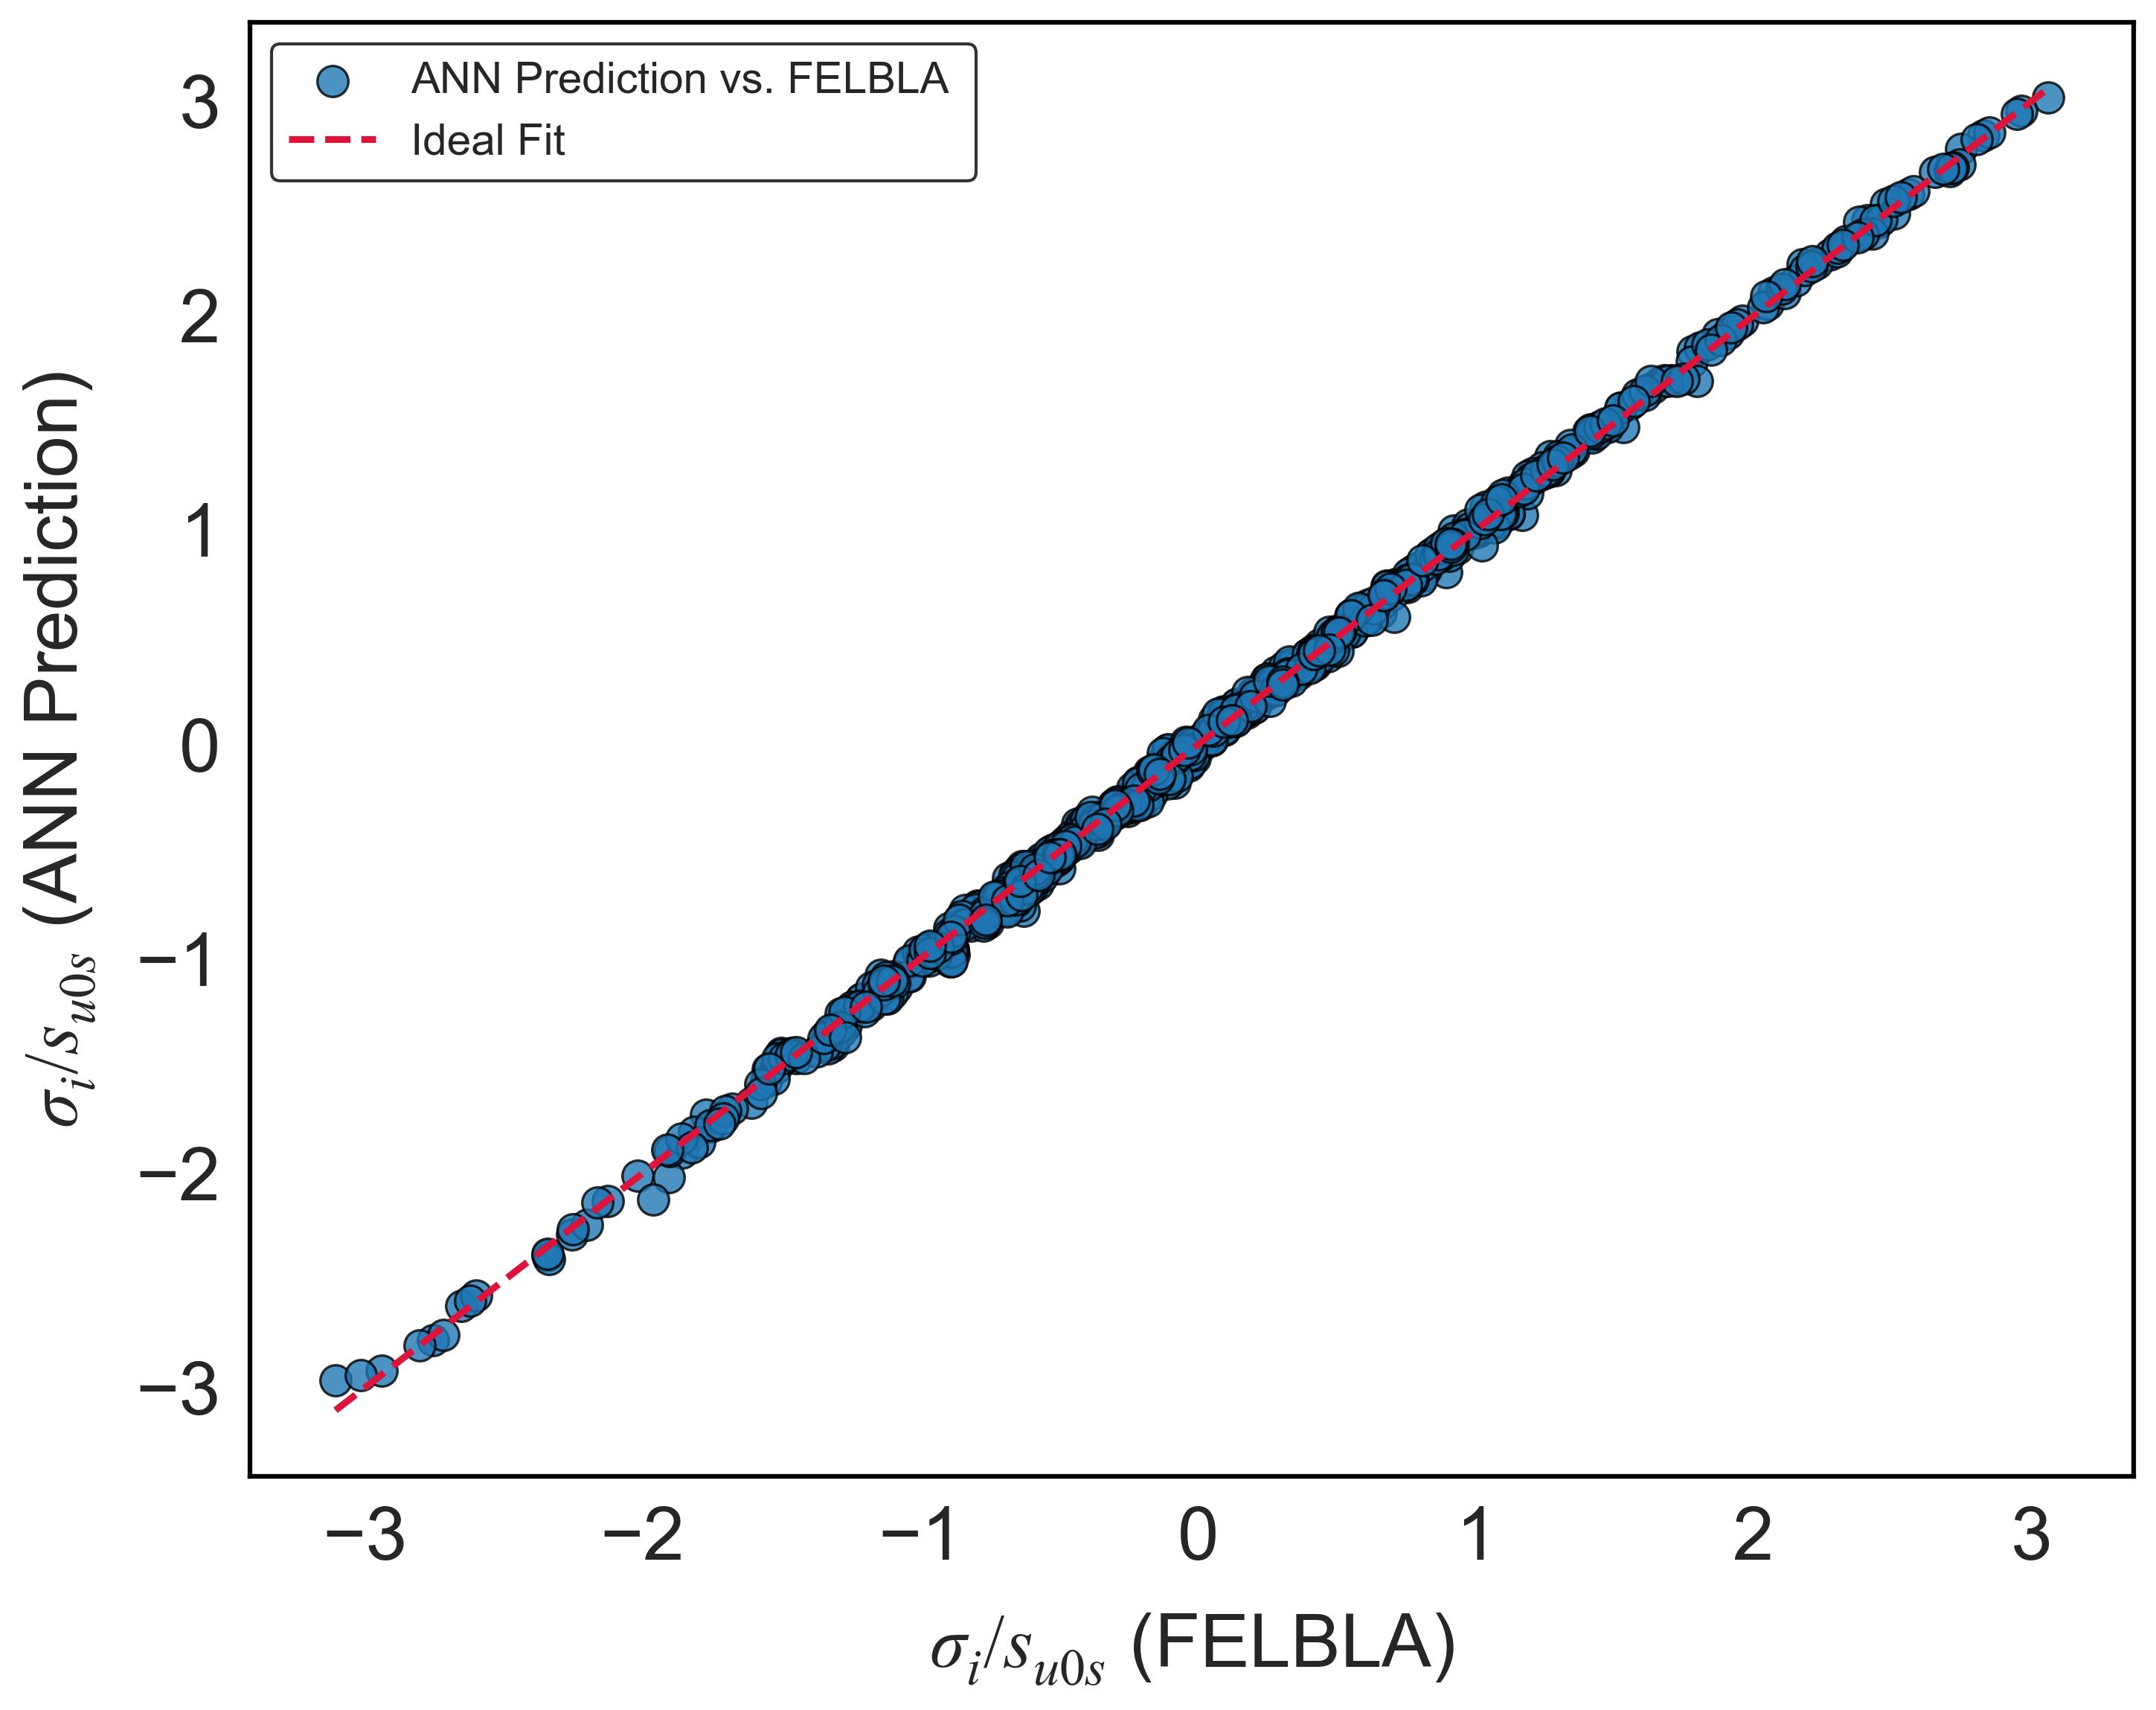

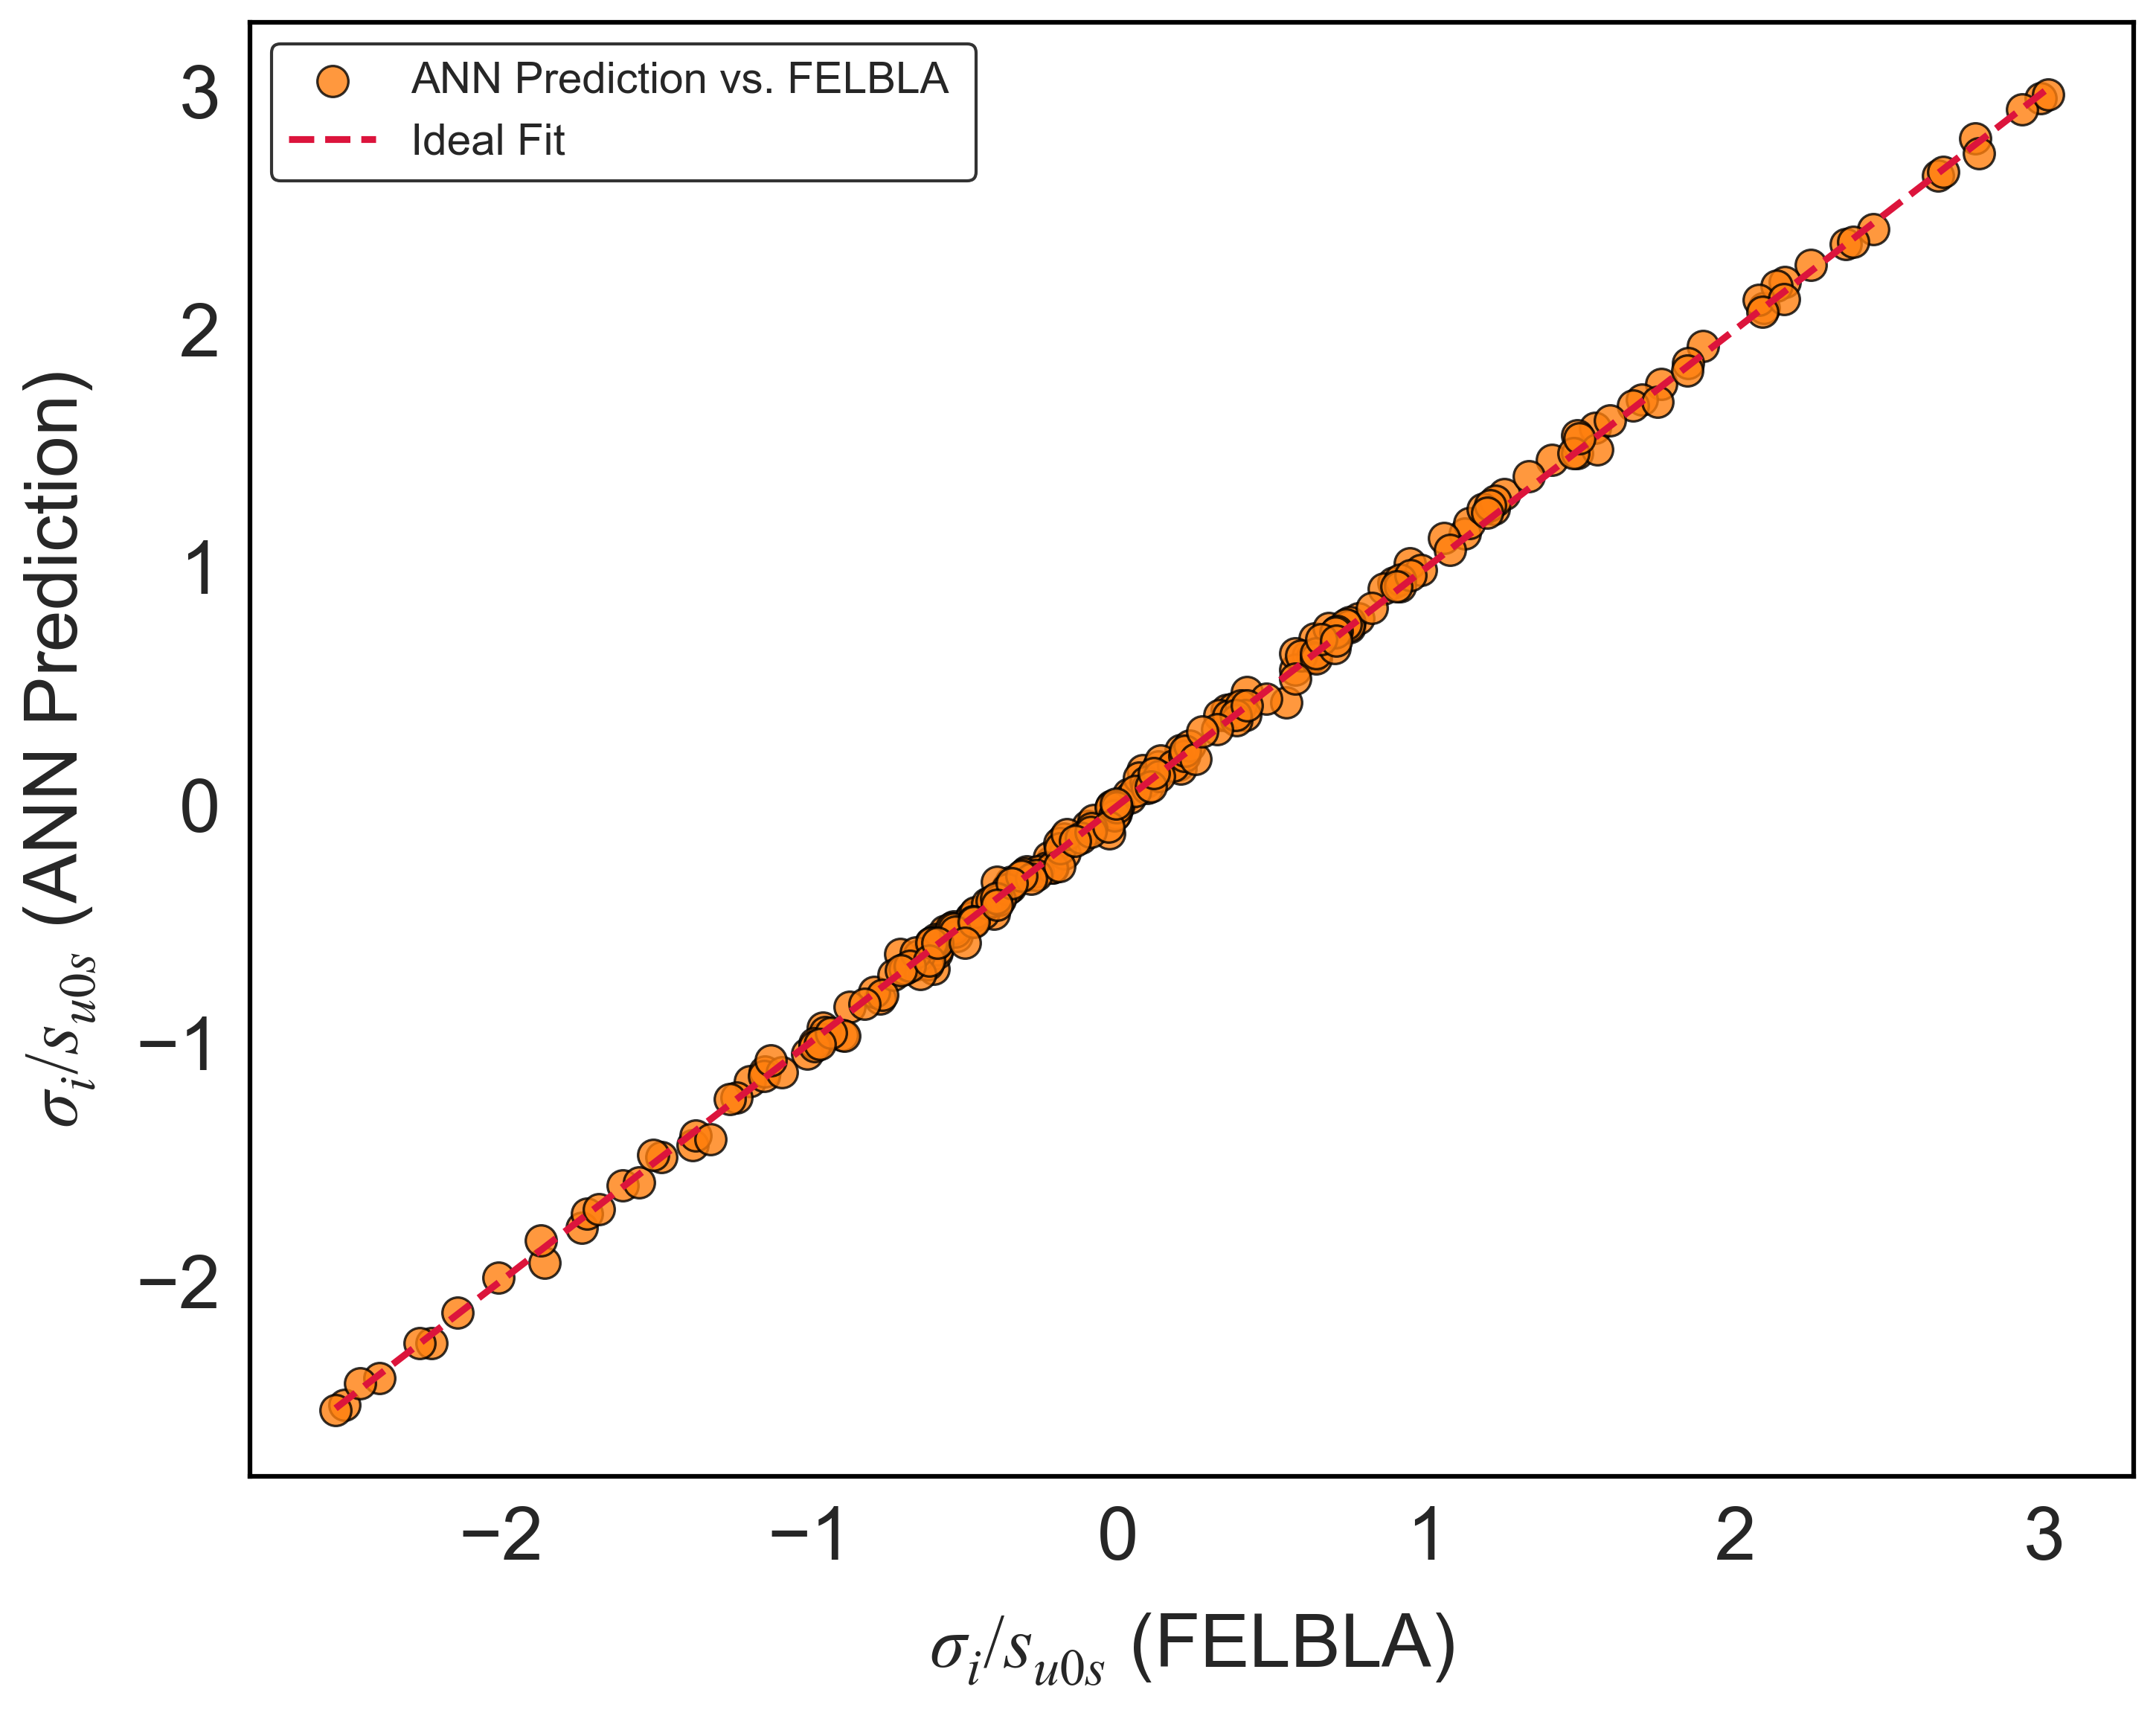

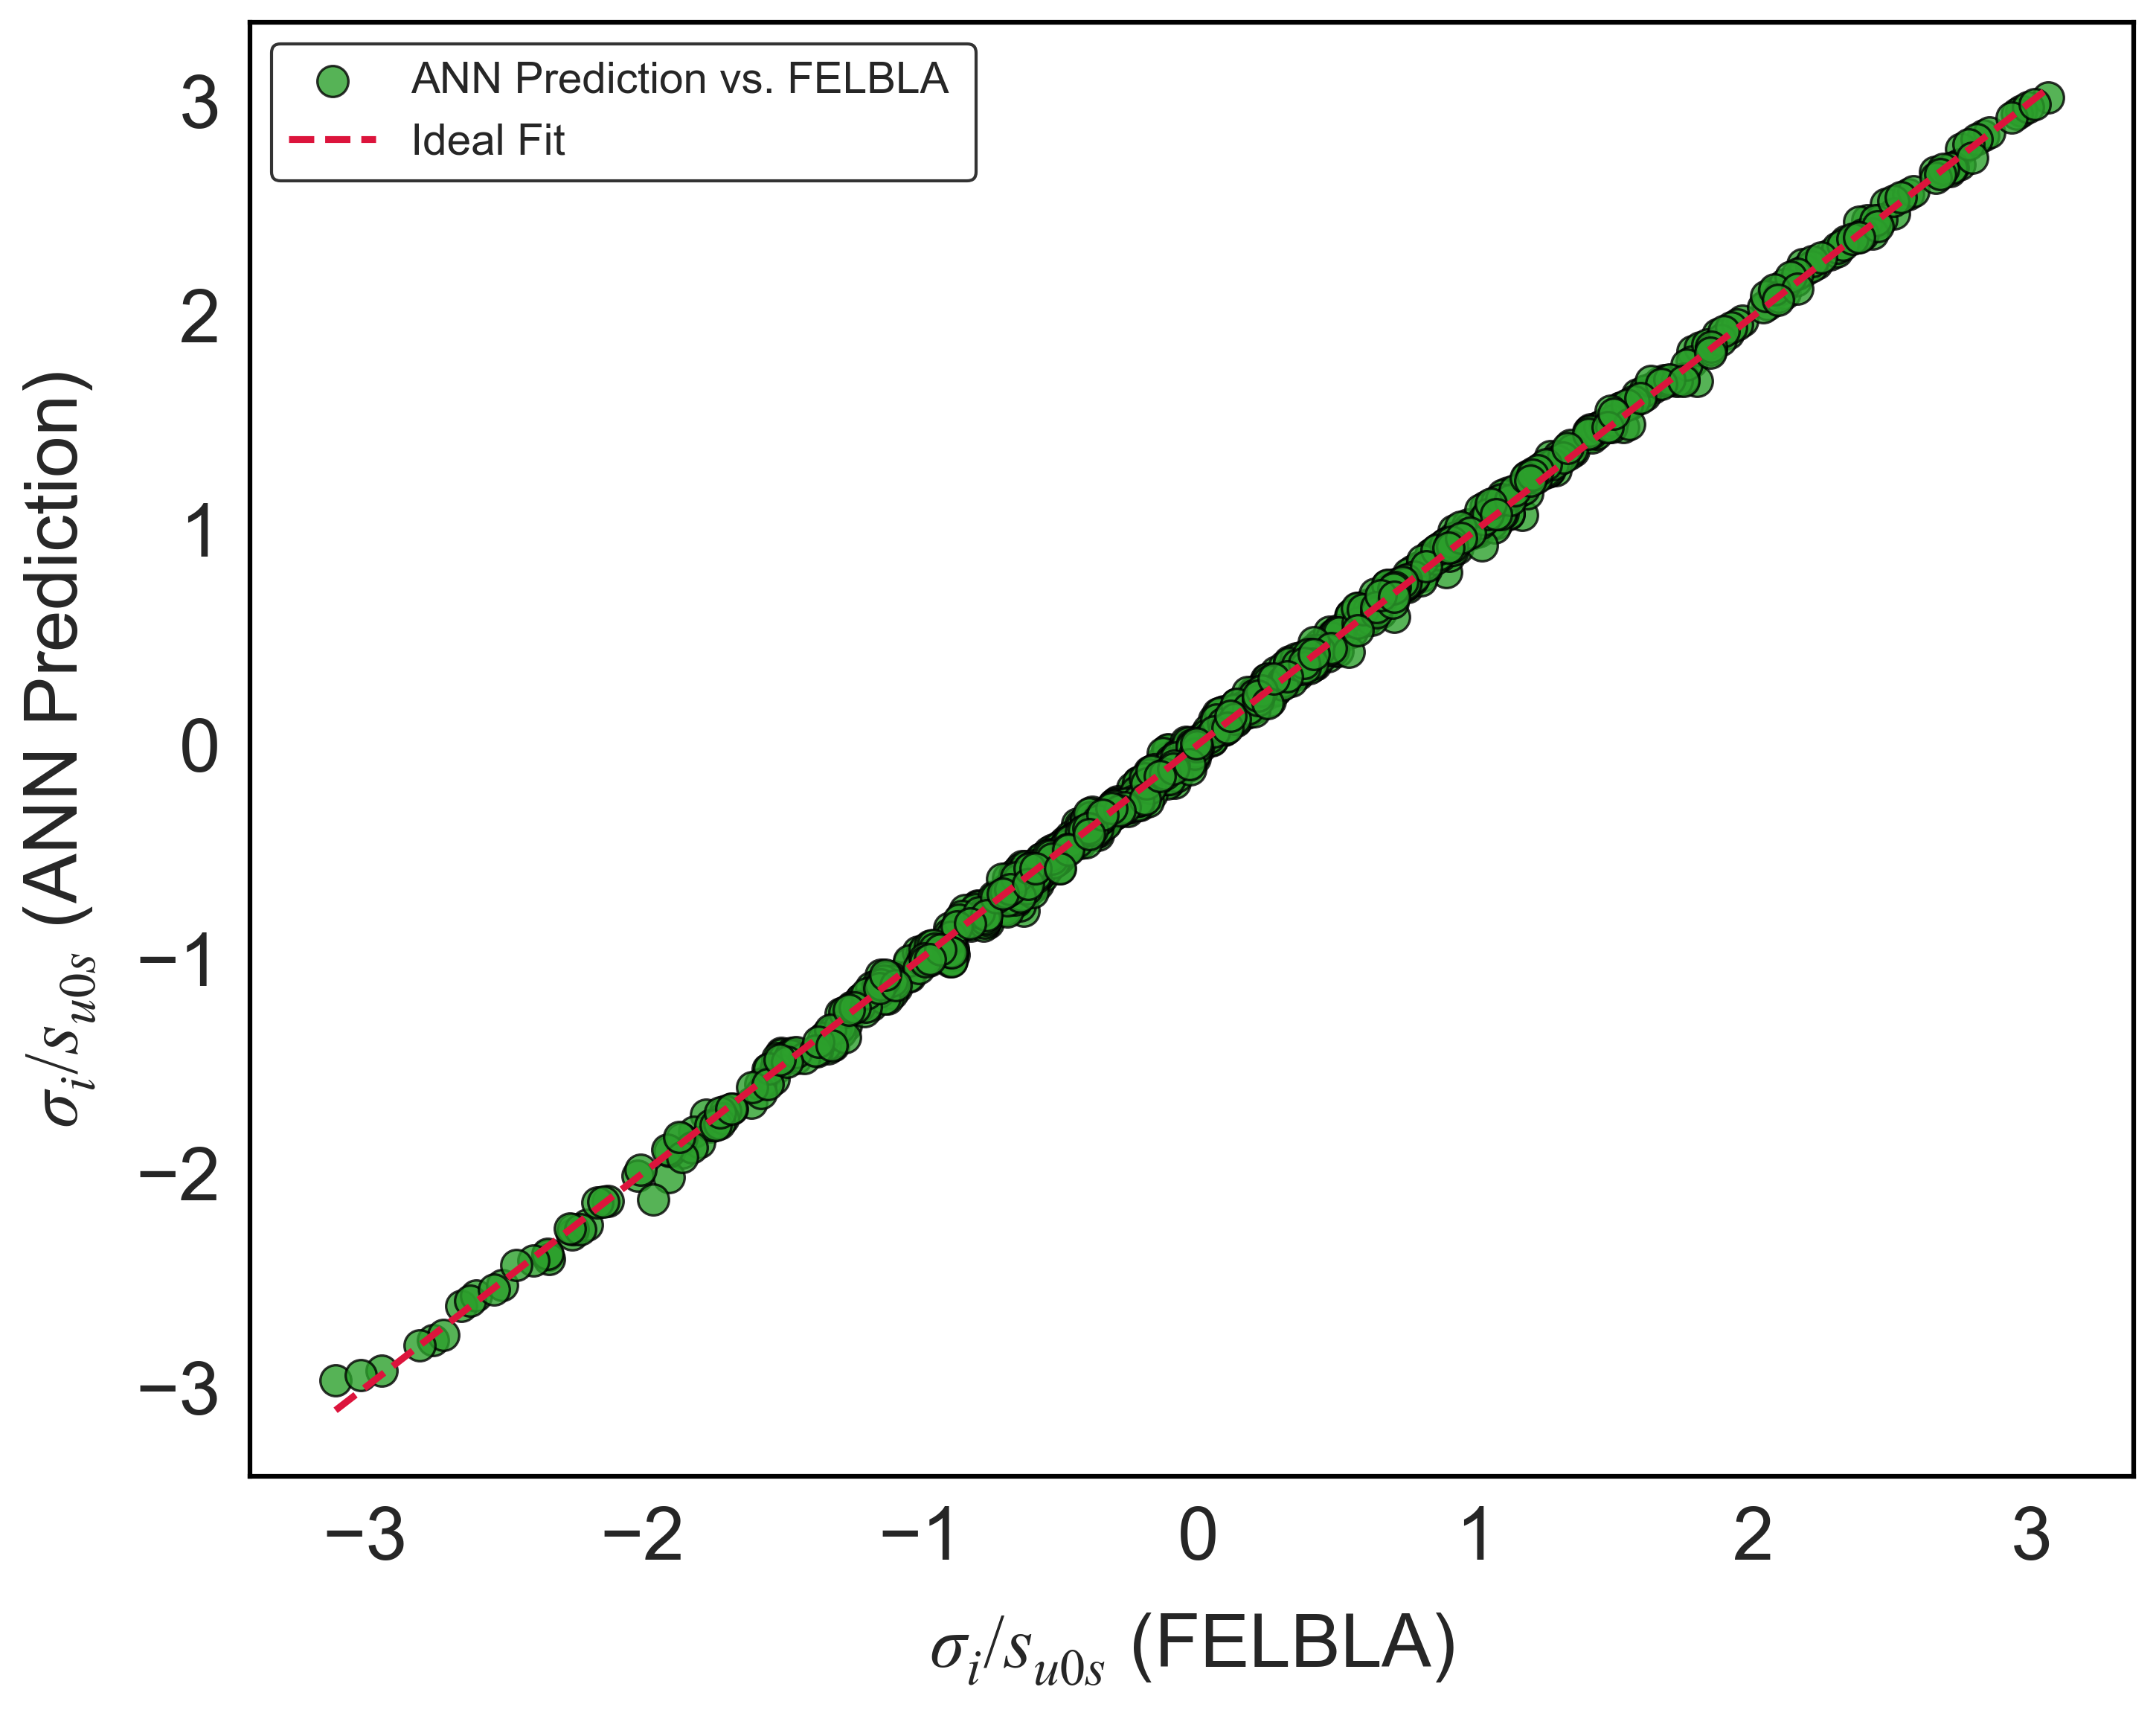

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on training and test data
y_train_pred = model.predict(X_train_scaled).flatten()
y_test_pred = model.predict(X_test_scaled).flatten()

# Flatten the actual values
y_train_scaled = np.array(y_train_scaled).flatten()
y_test_scaled = np.array(y_test_scaled).flatten()

# Combine for total data
y_total = np.concatenate((y_train_scaled, y_test_scaled))
y_total_pred = np.concatenate((y_train_pred, y_test_pred))

# Set global font to Times New Roman
plt.rcParams.update({
    "font.family": "Times New Roman",
    "mathtext.fontset": "custom",
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold"
})

sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

# Function to plot scatter plots
def plot_scatter(y_true, y_pred, color, filename, legend_label):
    plt.figure(figsize=(10, 8), dpi=300)

    # Scatter plot
    sns.scatterplot(
        x=y_true,
        y=y_pred,
        color=color,
        edgecolor='black',
        alpha=0.8,
        s=100,
        linewidth=0.8,
        label=legend_label
    )

    # Ideal fit line y = x
    plt.plot(
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        linestyle='--',
        color='crimson',
        linewidth=2.2,
        label='Ideal Fit'
    )

    # Axis labels
    plt.xlabel(r'$\mathit{\sigma_i/s_{u0s}}$ (FELBLA)', fontsize=24, labelpad=12)
    plt.ylabel(r'$\mathit{\sigma_i/s_{u0s}}$ (ANN Prediction)', fontsize=24, labelpad=12)

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    # Full black box border
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_color('black')

    plt.grid(False)
    plt.title('', fontsize=0)
    plt.legend(fontsize=14, loc='upper left', frameon=True, edgecolor='black')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# Plot for train, test, total
plot_scatter(y_train_scaled, y_train_pred, "#1f77b4", "train_plot.png", "ANN Prediction vs. FELBLA ")
plot_scatter(y_test_scaled, y_test_pred, "#ff7f0e", "test_plot.png", "ANN Prediction vs. FELBLA ")
plot_scatter(y_total, y_total_pred, "#2ca02c", "total_plot.png", "ANN Prediction vs. FELBLA ")


### Feature Importance Analysis

Epoch 1/500
59/59 [==============================] - 1s 6ms/step - loss: 0.2757 - val_loss: 0.0477
Epoch 2/500
59/59 [==============================] - 0s 3ms/step - loss: 0.0252 - val_loss: 0.0147
Epoch 3/500
59/59 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.0117
Epoch 4/500
59/59 [==============================] - 0s 4ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 5/500
59/59 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 6/500
59/59 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0095
Epoch 7/500
59/59 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 8/500
59/59 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0107
Epoch 9/500
59/59 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0081
Epoch 10/500
59/59 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 11/

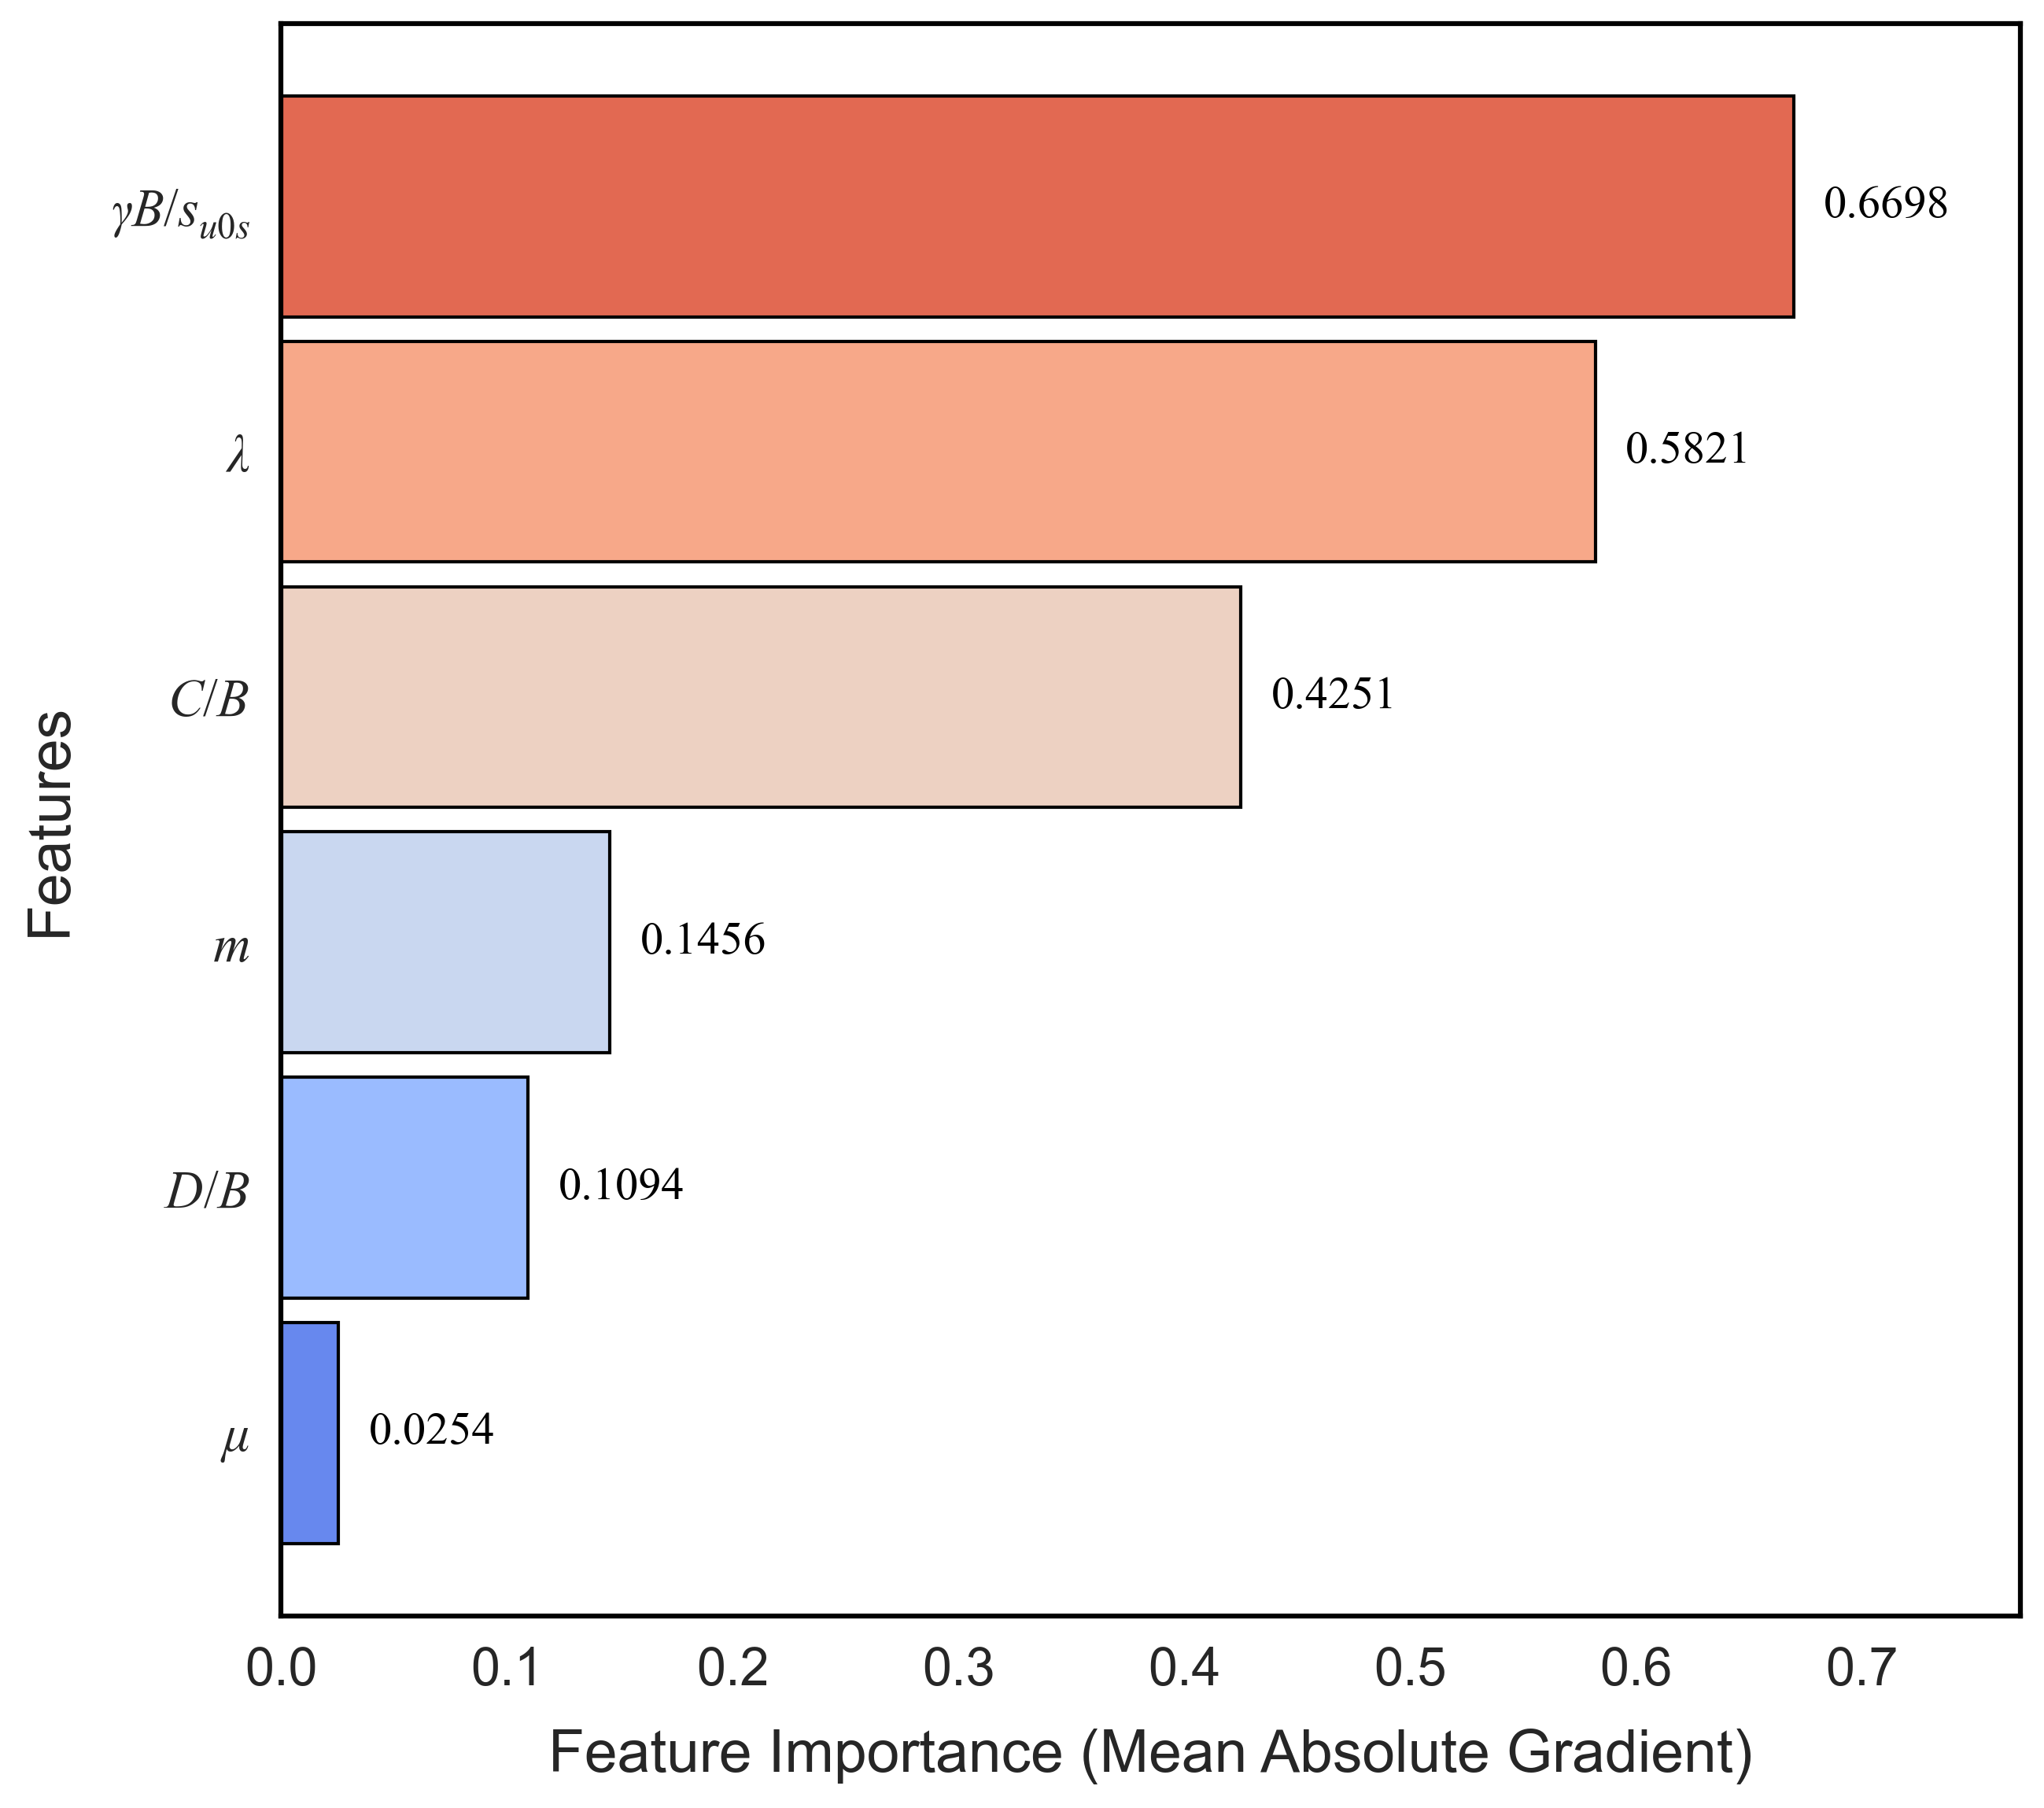

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# ========== Global Style Settings ==========
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'figure.dpi': 300
})
sns.set_style("white")

# ========== Define and Train ANN Model ==========
model = Sequential([
    Dense(18, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=16,
                    validation_data=(X_test_scaled, y_test_scaled),
                    verbose=1, callbacks=[early_stop])

# ========== Evaluate Model ==========
y_pred = model.predict(X_test_scaled).flatten()

r2 = r2_score(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_scaled, y_pred)

# ========== Gradient-Based Feature Importance ==========
with tf.GradientTape() as tape:
    inputs = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
    tape.watch(inputs)
    predictions = model(inputs)
grads = tape.gradient(predictions, inputs)
feature_importance = np.mean(np.abs(grads.numpy()), axis=0)

# ========== Feature Names ==========
feature_names = [
    r'$C/B$', 
    r'$D/B$', 
    r'$\lambda$', 
    r'$\mu$', 
    r'$m$', 
    r'$\gamma B / s_{u0s}$'
]

# Sort by importance for cleaner plot
feature_names, feature_importance = zip(*sorted(zip(feature_names, feature_importance), key=lambda x: x[1]))

# ========== Plot Feature Importance (Square-like Layout, Fixed) ==========
plt.figure(figsize=(9, 8))  # Slightly wider to fit text
colors = sns.color_palette("coolwarm", len(feature_names))
bars = plt.barh(range(len(feature_names)), feature_importance,
                align='center', color=colors, edgecolor='black', height=0.9)

# Axis labels and ticks
plt.yticks(range(len(feature_names)), feature_names, fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'Feature Importance (Mean Absolute Gradient)', fontsize=18, labelpad=10)
plt.ylabel(r'Features', fontsize=18, labelpad=10)

# Add value labels and compute max for padding
max_val = max(feature_importance)
for bar in bars:
    width = bar.get_width()
    plt.text(width + max_val * 0.02, bar.get_y() + bar.get_height() / 2,
             f'{width:.4f}', ha='left', va='center',
             fontsize=14, fontname="Times New Roman", color='black')

# Set x-limits to give room for text labels
plt.xlim(0, max_val * 1.15)

# Add full box outline
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('black')

plt.grid(False)
plt.tight_layout()
plt.savefig("feature_importance_plot_square_fixed.png", dpi=300, bbox_inches='tight')
plt.show()


### Inspection of Weights and Biases in the Neural Network

In [32]:
import numpy as np
import pandas as pd

# Extract weights and biases from the trained model
weights_biases = model.get_weights()

# Extract weights and biases for each layer
w1, b1 = weights_biases[0], weights_biases[1]  # First hidden layer
w2, b2 = weights_biases[2], weights_biases[3]  # Output layer

# Round off weights and biases for better readability
w1 = np.round(w1, 4)
b1 = np.round(b1, 4)
w2 = np.round(w2, 4)
b2 = np.round(b2, 4)

# Convert weights into DataFrames
df_w1 = pd.DataFrame(w1, columns=[f'Neuron {i+1}' for i in range(w1.shape[1])])
df_w1.index = [f'Feature {i+1}' for i in range(w1.shape[0])]

df_b1 = pd.DataFrame(b1, columns=['Bias'])
df_b1.index = [f'Neuron {i+1}' for i in range(b1.shape[0])]

df_w2 = pd.DataFrame(w2, columns=['Output Neuron'])
df_w2.index = [f'Neuron {i+1}' for i in range(w2.shape[0])]

df_b2 = pd.DataFrame(b2, columns=['Bias'])
df_b2.index = ['Output Neuron']

# Export all DataFrames to CSV
df_w1.to_csv("weights_hidden_layer.csv")
df_b1.to_csv("biases_hidden_layer.csv")
df_w2.to_csv("weights_output_layer.csv")
df_b2.to_csv("bias_output_layer.csv")

# Print weights and biases in markdown format
print("\n" + "="*50)
print("🔹 Weights of the First Hidden Layer")
print("="*50)
print(df_w1.to_markdown())

print("\n" + "="*50)
print("🔹 Biases of the First Hidden Layer")
print("="*50)
print(df_b1.to_markdown())

print("\n" + "="*50)
print("🔹 Weights of the Output Layer")
print("="*50)
print(df_w2.to_markdown())

print("\n" + "="*50)
print("🔹 Bias of the Output Layer")
print("="*50)
print(df_b2.to_markdown())



🔹 Weights of the First Hidden Layer
|           |   Neuron 1 |   Neuron 2 |   Neuron 3 |   Neuron 4 |   Neuron 5 |   Neuron 6 |   Neuron 7 |   Neuron 8 |   Neuron 9 |   Neuron 10 |   Neuron 11 |   Neuron 12 |   Neuron 13 |   Neuron 14 |   Neuron 15 |   Neuron 16 |   Neuron 17 |   Neuron 18 |
|:----------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|
| Feature 1 |     0.0054 |     0.1148 |     0.7625 |     0.2856 |     0.2908 |     0.4149 |    -0.1406 |     0.4583 |     0.4918 |      0.5757 |      0.2482 |     -0.4767 |     -0.1368 |      0.2147 |      0.7141 |     -0.2541 |     -0.6108 |     -0.3756 |
| Feature 2 |     0.0753 |    -0.058  |    -0.1102 |     0.1676 |     0.0484 |     0.1703 |     0.1212 |     0.0897 |    -0.1975 |      0.0765 |     -0.1151 |      0.007  |     -0.1632 |      